
# Trabalho de Sistemas Inteligentes para a Bioinformática

Trabalho realizado no âmbito da unidade curricular de Sistemas Inteligentes para a Bioinformática.

Grupo constituído por:

    - Angelina Eiras PG42861
    - Carina Gonçalves PG45466
    - Rute Castro PG45475
    - Sónia Carvalho PG42882


# A alterar:

    - Fazer análise com base na literatura, exemplo, ponto em que a termoestabilidade representa a estabilidade etc
    - não e preciso normalizar (podemos fazer scale e apenas no X), 
    - machine learning com regressão (tm variável continua)

<del> - Poucos descritores: gerar mais com o propythia; - Separar o x do y antes de fazer standardscaler e usar o y sem alterar os valores; - Retirar valores de pH maiores que 14; Aumentar número de features <del>

Para a utilização deste notebook é necessário proceder às seguintes instalações:

In [1]:
# pip install git+https://github.com/jcapels/propythia.git@fix_dependencies
#ou download do ficheiro em formato zip
# pip install --upgrade pip
# pip install propythia-fix_dependencies.zip
# pip install -r requirements.txt

In [2]:
import pandas as pd
import scipy.cluster.hierarchy
import seaborn as sn
import numpy as np
from tensorflow import keras
from keras.optimizers.schedules import *
from propythia import *
from scipy import stats
from statsmodels.stats.weightstats import ztest as ztest
import statsmodels.api as statsmodels
import matplotlib.pyplot as plt
%matplotlib inline

import re
import random
import requests as r
from Bio import SeqIO
from io import StringIO
from collections import Counter
import seaborn as sns

from propythia.protein_descriptores import ProteinDescritors

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, chi2, f_classif, SelectPercentile, r_regression
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, matthews_corrcoef, f1_score, roc_auc_score, log_loss, hinge_loss, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, LeaveOneOut
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.pipeline import make_pipeline
from scipy.stats import uniform, shapiro, levene, mannwhitneyu, ttest_ind
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import load_iris

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt

------------------------------------------------------------------------------------------------------------------------------------------------------

#  Fase 1 

## Exploração inicial

Nesta secção são apresentados os dados provenientes do desafio Kaggle (https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction). Os datasets abordam o tema de enzimas que são proteínas que atuam como catalisadores nas reações químicas dos organismos vivos.
O objetivo do trabalho é prever a termoestabilidade de variantes enzimáticas, uma vez que compreender e prever com precisão a estabilidade da proteína é um problema fundamental na biotecnologia. Melhorias na estabilidade da enzima podem reduzir os custos e aumentar a velocidade que os cientistas podem iterar nos conceitos.
Os dados de termoestabilidade (temperatura de fusão) foram medidos experimentalmente e incluem sequências naturais, bem como sequências modificadas com mutações únicas ou múltiplas nas sequências naturais.


## Pré-processamento

Os primeiros passos tomados vão juntar os datasets provenientes do desafio - `train` e `train_update`, e juntá-los numa única DataFrame.
De seguida, vamos extender os dados existentes com descritores físico-químicos obtidos com o Propythia, desenvolvido na Universidade do Minho, que vão ser utilizados para o resto do trabalho.

In [184]:
# Ler os datasets provenientes do desafio
train = pd.read_csv('datasets/train_nanFREE.csv', delimiter = ',')
updates = pd.read_csv('datasets/train_updates_20220929.csv', delimiter = ',')


# Verificar tamanho e primeiras linhas/colunas do dataset train
print(train.shape)
train.head()

(28723, 5)


,Unnamed: 0,seq_id,protein_sequence,pH,tm
0,0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5


In [185]:
# Verificar tamanho e primeiras linhas/colunas do dataset de updates
print(updates.shape)
updates.head()

(2434, 5)


,seq_id,protein_sequence,pH,data_source,tm
0,69,NaN,NaN,NaN,NaN
1,70,NaN,NaN,NaN,NaN
2,71,NaN,NaN,NaN,NaN
3,72,NaN,NaN,NaN,NaN
4,73,NaN,NaN,NaN,NaN


In [186]:
# Colunas para atualizar no dataset de treino
col_to_update = ['protein_sequence', 'pH', 'tm']

# Atualizar o seq_id
to_update_id = list(updates[~updates.protein_sequence.isna()].seq_id)

# Fazer o update só nas linhas que são necessarias
updates = updates[updates.seq_id.isin(to_update_id)].set_index('seq_id')

# Atualizar os valores no dataset de treino
train.loc[to_update_id, col_to_update] = updates[col_to_update].values

# Verificar se está com os updates
pd.concat([train[train.seq_id.isin(to_update_id)].set_index('seq_id'), updates], axis = 1)

# Retirar os pHs maiores que 14
train = train[train["pH"]<=14] 

# Verificar tamanho e primeiras linhas/colunas
print(train.shape)
train.head()

(28723, 5)


,Unnamed: 0,seq_id,protein_sequence,pH,tm
0,0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5


### Gerar descritores

Dos métodos disponíveis na classe `ProteinDescriptors`, faz sentido utilizar cinco destes pelos seguintes motivos:
- `get_all_aac()`: descritores relacionados com a composição dos aminoácidos;
- `get_all_physicochemical()`: tem 16 features disponíveis relativas às propriedades fisico-químicas, incluindo include length, charge,charge density, formula (number of C,H,N,O and S in the sequence), number of 4 types of molecular bonds (total, single,double and hydrogen bonds), the molecular weight, GRAVY, aromacity, isoelectric point, instability index, values for secondary structures (a-helix, turns and b-sheets), molar extinction coefficient, flexibility, aliphatic index, boman index and hydrophobic ratio;
- `get_all_base_class()`: descritores relativos à classe base dos peptidos, permitindo calcular the sequence moment, the global averaging descriptor, hydrophocity moments, arcs, autocorrelation and cross correlation of amino acid values for a given descriptor value;
- `get_all_sequenceorder()`: descritores da ordem da sequência, permitindo calcular sequence order coupling numbers e quasi
sequence order values;
- `get_all_correlation()`: descritores de correlação, incluindo Normalized Moreau-Broto autocorrelation, Moran Autocorrelation e Geary autocorrelation.

Foi também testada a possibilidade de utilizar o `get_all()`, que também englobaria estes, mas o peso computacional deste método era demasiado grande.
Por questões de "performance" - e por forma a salvaguardar o progresso do nosso trabalho, cada um dos métodos mencionados foi calculado individualmente e guardado em ficheiros dedicados, procedendo-se à sua agregação num momento posterior.

In [32]:
# Calcular toda a informação extra
print("running get_all_aac")
result_all_aac : pd.DataFrame = ProteinDescritors(dataset=train, col='protein_sequence').get_all_aac(n_jobs=96)
result_all_aac.to_csv('datasets/get_all_aac.csv')

print("running get_all_physicochemical")
result_all_physicochemical : pd.DataFrame = ProteinDescritors(dataset=train, col='protein_sequence').get_all_physicochemical(n_jobs=96)
result_all_physicochemical.to_csv('datasets/get_all_physicochemical.csv')

print("running get_all_base_class")
result_all_base_class : pd.DataFrame = ProteinDescritors(dataset=train, col='protein_sequence').get_all_base_class(window=5, n_jobs=96)
result_all_base_class.to_csv('datasets/get_all_base_class.csv')

print("running get_all_sequenceorder")
result_all_sequenceorder : pd.DataFrame = ProteinDescritors(dataset=train, col='protein_sequence').get_all_sequenceorder(maxlag_socn=5,maxlag_qso=5, n_jobs=96) # Falhou
result_all_sequenceorder.to_csv('datasets/get_all_sequenceorder.csv')

print("running get_all_correlation")
result_all_correlation : pd.DataFrame = ProteinDescritors(dataset=train, col='protein_sequence').get_all_correlation(n_jobs=96)
result_all_correlation.to_csv('datasets/get_all_correlation.csv')

running get_all_aac
running get_all_physicochemical
running get_all_base_class
running get_all_sequenceorder
running get_all_correlation
merging
dumping


In [25]:
# Junção dos resultados num único dataset - all_descriptors.csv
datasets = [
   'datasets/get_all_physicochemical.csv',
   'datasets/get_all_sequenceorder.csv',
   'datasets/get_all_correlation.csv',
   'datasets/get_all_base_class.csv',
   'datasets/get_all_aac.csv'
   ]

dataset = pd.DataFrame()
for dataset in datasets:
   dataset = pd.read_csv(dataset, delimiter = ',')
   dataset = dataset if dataset.empty else dataset.merge(dataset, how='inner', on = "protein_sequence", validate="one_to_one")
# dataset = dataset.loc[:,~dataset.columns.duplicated()] # remove duplicates não funciona porque o join() mete sufixos quando os nomes são iguais

print("dumping")
dataset.to_csv('datasets/all_descriptors.csv') 

# Visualizar tamanho e primeiras linhas/colunas
print(dataset.shape)
dataset.head()

C:\Users\SOA5BRG\AppData\Local\Temp\ipykernel_17520\2114072168.py:13: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0.1_x', 'tm_x', 'Unnamed: 0_x', 'pH_x', 'seq_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  descriptors_df = dataframe if descriptors_df.empty else descriptors_df.merge(dataframe, how='inner', on = "protein_sequence", validate="one_to_one")


dumping
(28701, 9270)


,Unnamed: 0.1_x,Unnamed: 0_x,seq_id_x,protein_sequence,pH_x,tm_x,length,charge,chargedensity,formulaC,...,VVL,VVK,VVM,VVF,VVP,VVS,VVT,VVW,VVY,VVV
0,0,0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341.0,-1.732,-0.000048,1622,...,0,1,0,0,0,0,1,0,0,0
1,1,1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286.0,-12.537,-0.000382,1385,...,1,0,0,0,0,0,0,0,0,0
2,2,2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497.0,11.513,0.000215,2290,...,0,0,0,0,0,0,0,0,0,0
3,3,3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265.0,-20.606,-0.000699,1293,...,0,0,0,0,0,0,0,0,0,0
4,4,4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1451.0,-21.900,-0.000138,6948,...,0,0,0,0,1,3,0,0,0,2


### Pré-processamento de dados
Com a junção dos resultados obtidos a partir do ProteinDescriptors, foram introduzidos alguns artefactos no dataset, nomeadamente colunas duplicadas, marcadas com `_x`, `_y`, entre outros.
Torna-se assim necessário efetuar pré-processamento antes de proceder à análise dos dados propriamente dita.

In [3]:
# Carregar o dataset que inclui todos os descritores
dataset = pd.read_csv('datasets/all_descriptors.csv', delimiter = ',')

# Visualizar tamanho, tipo de dados e descrição
print(dataset.shape, dataset.dtypes)
dataset.describe()

# As variáveis têm valores em gamas muito diferentes, vai ser preciso fazer normalização dos dados
# Há também colunas duplicadas  resultantes do merge(), que ficaram com sufixos _x e _y, outras que são Unnamed.
# A coluna seq_id tem mais valores que o indicado pela shape

(28701, 9271) Unnamed: 0.2         int64
Unnamed: 0.1_x       int64
Unnamed: 0_x         int64
seq_id_x             int64
protein_sequence    object
                     ...  
VVS                  int64
VVT                  int64
VVW                  int64
VVY                  int64
VVV                  int64
Length: 9271, dtype: object


,Unnamed: 0.2,Unnamed: 0.1_x,Unnamed: 0_x,seq_id_x,pH_x,tm_x,length,charge,chargedensity,formulaC,...,VVL,VVK,VVM,VVF,VVP,VVS,VVT,VVW,VVY,VVV
count,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,...,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000
mean,14350.000000,14350.000000,15551.295878,15551.295878,6.939714,49.366046,468.942197,-5.373652,-0.000061,2296.848925,...,0.170865,0.128393,0.041741,0.075990,0.109717,0.173374,0.128114,0.020975,0.055294,0.160587
std,8285.409374,8285.409374,9222.759275,9222.759275,0.618851,13.722043,663.358958,19.323826,0.000334,3240.829212,...,0.457690,0.470298,0.219756,0.293677,0.463418,0.516936,0.491245,0.231144,0.244326,0.444982
min,0.000000,0.000000,0.000000,0.000000,1.990000,0.000000,5.000000,-903.437000,-0.002708,22.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7175.000000,7175.000000,7450.000000,7450.000000,7.000000,42.300000,219.000000,-9.834000,-0.000232,1086.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14350.000000,14350.000000,15190.000000,15190.000000,7.000000,48.000000,356.000000,-3.336000,-0.000082,1750.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21525.000000,21525.000000,23711.000000,23711.000000,7.000000,53.500000,545.000000,3.029000,0.000086,2688.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,28700.000000,28700.000000,31389.000000,31389.000000,11.000000,130.000000,32767.000000,396.696000,0.002890,161074.000000,...,7.000000,19.000000,5.000000,5.000000,20.000000,13.000000,20.000000,12.000000,3.000000,11.000000


In [6]:
# Remove colunas que contém "Unnamed" no início, chamam-se '_', ou têm sufixo indicativo de duplicado
dataset = dataset.loc[:, ~dataset.columns.str.contains('^Unnamed')]
dataset = dataset.loc[:, ~dataset.columns.str.fullmatch('_')]
# find duplicate column names (from merge) and remove them
# seq_id_x.1  tm_x.1  seq_id_y.1  tm_y.1
for col in filter(lambda x:x.endswith('_y'), dataset.columns):
    dataset = dataset.drop(col, axis=1)
for col in filter(lambda x:x.endswith('_x'), dataset.columns):
    dataset = dataset.rename(columns={col:col[-2]})
for col in filter(lambda x:'0'<=x[-1]<='9' and x[-2]=='.', dataset.columns):
    dataset = dataset.drop(col, axis=1)


In [7]:
# Colunas que contém o nome "Unnamed" no início, chamam-se '_', ou têm sufixo indicativo de duplicado
for col in dataset.columns:
    if col.startswith("Unnamed") or col.startswith("_") or col.endswith("_x") or col.endswith("_y") or "0"<=col[0]<"9":
        print(col)
# É necessário _recorrer_ a anterior e esta

In [8]:
# Confirmar que não há dados omissos
set(dataset.isnull().sum())
# Só há valores 0, o que indica que todas as colunas tem 0 valores omissos

{0}

In [9]:
# Eliminar linhas duplicadas, drop das duas colunas para ser possível fazer o pre porcessamento dos dados
# Isto faz sentido porque já extraímos a informação da sequência (features vindas do ProteinDescriptors)
dataset_dropped = dataset.drop_duplicates(subset = "seq_id")
dataset_dropped = dataset_dropped.drop(columns=['seq_id', 'protein_sequence'], axis=1)
dataset_dropped.shape

(28701, 9246)

### Análise exploratória inicial
Na análise exploratória inicial, tentámos resumir e visualizar as características principais das "features", com recurso a alguns métodos estatísticos.

In [10]:
# Resumo das principais métricas estatísticas
dataset.describe()

,length,charge,chargedensity,formulaC,formulaH,formulaN,formulaO,formulaS,tot,hydrogen,...,VVL,VVK,VVM,VVF,VVP,VVS,VVT,VVW,VVY,VVV
count,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.0,28701.0,...,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000
mean,468.942197,-5.373652,-0.000061,2296.848925,3603.084945,619.323403,724.173722,17.669628,0.0,0.0,...,0.170865,0.128393,0.041741,0.075990,0.109717,0.173374,0.128114,0.020975,0.055294,0.160587
std,663.358958,19.323826,0.000334,3240.829212,5117.825509,868.292488,1037.634028,22.715777,0.0,0.0,...,0.457690,0.470298,0.219756,0.293677,0.463418,0.516936,0.491245,0.231144,0.244326,0.444982
min,5.000000,-903.437000,-0.002708,22.000000,40.000000,8.000000,7.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,219.000000,-9.834000,-0.000232,1086.000000,1700.000000,290.000000,334.000000,7.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,356.000000,-3.336000,-0.000082,1750.000000,2743.000000,469.000000,540.000000,13.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,545.000000,3.029000,0.000086,2688.000000,4187.000000,719.000000,834.000000,21.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,32767.000000,396.696000,0.002890,161074.000000,255327.000000,42607.000000,50595.000000,865.000000,0.0,0.0,...,7.000000,19.000000,5.000000,5.000000,20.000000,13.000000,20.000000,12.000000,3.000000,11.000000


Verificámos ter um número de features superior a 9,000. Algumas features têm um intervalo entre quartis igual a zero, o que tendencialmente não trará informação adicional ao nosso modelo, e poderá aumentar a sua complexidade. Assim, decidimos reduzir a dimensão do dataset através da eliminação de features com variância inferior a um certo threshold (que consideramos 0.5).

In [11]:
#Aplicar um threshold para seleccionar variáveis
vt = VarianceThreshold(threshold=0.5)
mask = vt.fit(dataset_dropped).get_support(indices=False)
dataset = dataset_dropped.loc[:, mask]

#Verificar se há colunas que possam ser interpretadas como binárias (apenas dois valores admissíveis)
binary_cols= [col for col in dataset.columns if len(dataset[col].unique())==2]
print("Binary columns:", binary_cols)

#Sumário das medidas estatísticas depois de eliminar features com variância inferior a 0.5
dataset.describe()

Binary columns: []


,length,charge,formulaC,formulaH,formulaN,formulaO,formulaS,MW_modlamp,IsoelectricPoint,Instability_index,...,TGL,TTT,TVT,VEK,VLD,VLE,VKE,VPE,VSA,VTG
count,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,2.870100e+04,28701.000000,28701.000000,...,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000,28701.000000
mean,468.942197,-5.373652,2296.848925,3603.084945,619.323403,724.173722,17.669628,5.231206e+04,6.754963,40.477556,...,0.159263,0.116128,0.128950,0.195150,0.181178,0.219609,0.168879,0.138114,0.175987,0.149995
std,663.358958,19.323826,3240.829212,5117.825509,868.292488,1037.634028,22.715777,7.380937e+04,1.692092,11.358696,...,0.770063,0.714995,0.917878,0.851397,0.746790,0.718904,0.736610,1.331978,0.737452,0.907485
min,5.000000,-903.437000,22.000000,40.000000,8.000000,7.000000,0.000000,5.276200e+02,4.050028,-7.383333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,219.000000,-9.834000,1086.000000,1700.000000,290.000000,334.000000,7.000000,2.457427e+04,5.407628,33.351489,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,356.000000,-3.336000,1750.000000,2743.000000,469.000000,540.000000,13.000000,3.955597e+04,6.149945,39.656029,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,545.000000,3.029000,2688.000000,4187.000000,719.000000,834.000000,21.000000,6.076843e+04,8.412367,46.765722,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,32767.000000,396.696000,161074.000000,255327.000000,42607.000000,50595.000000,865.000000,3.637297e+06,11.999968,141.642748,...,39.000000,82.000000,51.000000,46.000000,38.000000,32.000000,38.000000,82.000000,37.000000,51.000000


Ao selecionar as features com uma variância superior a 0.5, foi possível reduzir a dimensão do dataset (para um número de features igual a 125).
Constatámos que não existem colunas que possam ser interpretadas com binárias.

Procedeu-se então à análise de distribuição de cada feature.

array([[<AxesSubplot: title={'center': 'length'}>,
        <AxesSubplot: title={'center': 'charge'}>,
        <AxesSubplot: title={'center': 'formulaC'}>,
        <AxesSubplot: title={'center': 'formulaH'}>,
        <AxesSubplot: title={'center': 'formulaN'}>,
        <AxesSubplot: title={'center': 'formulaO'}>,
        <AxesSubplot: title={'center': 'formulaS'}>,
        <AxesSubplot: title={'center': 'MW_modlamp'}>,
        <AxesSubplot: title={'center': 'IsoelectricPoint'}>,
        <AxesSubplot: title={'center': 'Instability_index'}>,
        <AxesSubplot: title={'center': 'Molar_extinction_coefficient_reduced'}>],
       [<AxesSubplot: title={'center': 'Molar_extinction_coefficient_oxidized'}>,
        <AxesSubplot: title={'center': 'aliphatic_index'}>,
        <AxesSubplot: title={'center': 'tausw1'}>,
        <AxesSubplot: title={'center': 'tausw2'}>,
        <AxesSubplot: title={'center': 'tausw3'}>,
        <AxesSubplot: title={'center': 'tausw4'}>,
        <AxesSubplot: title

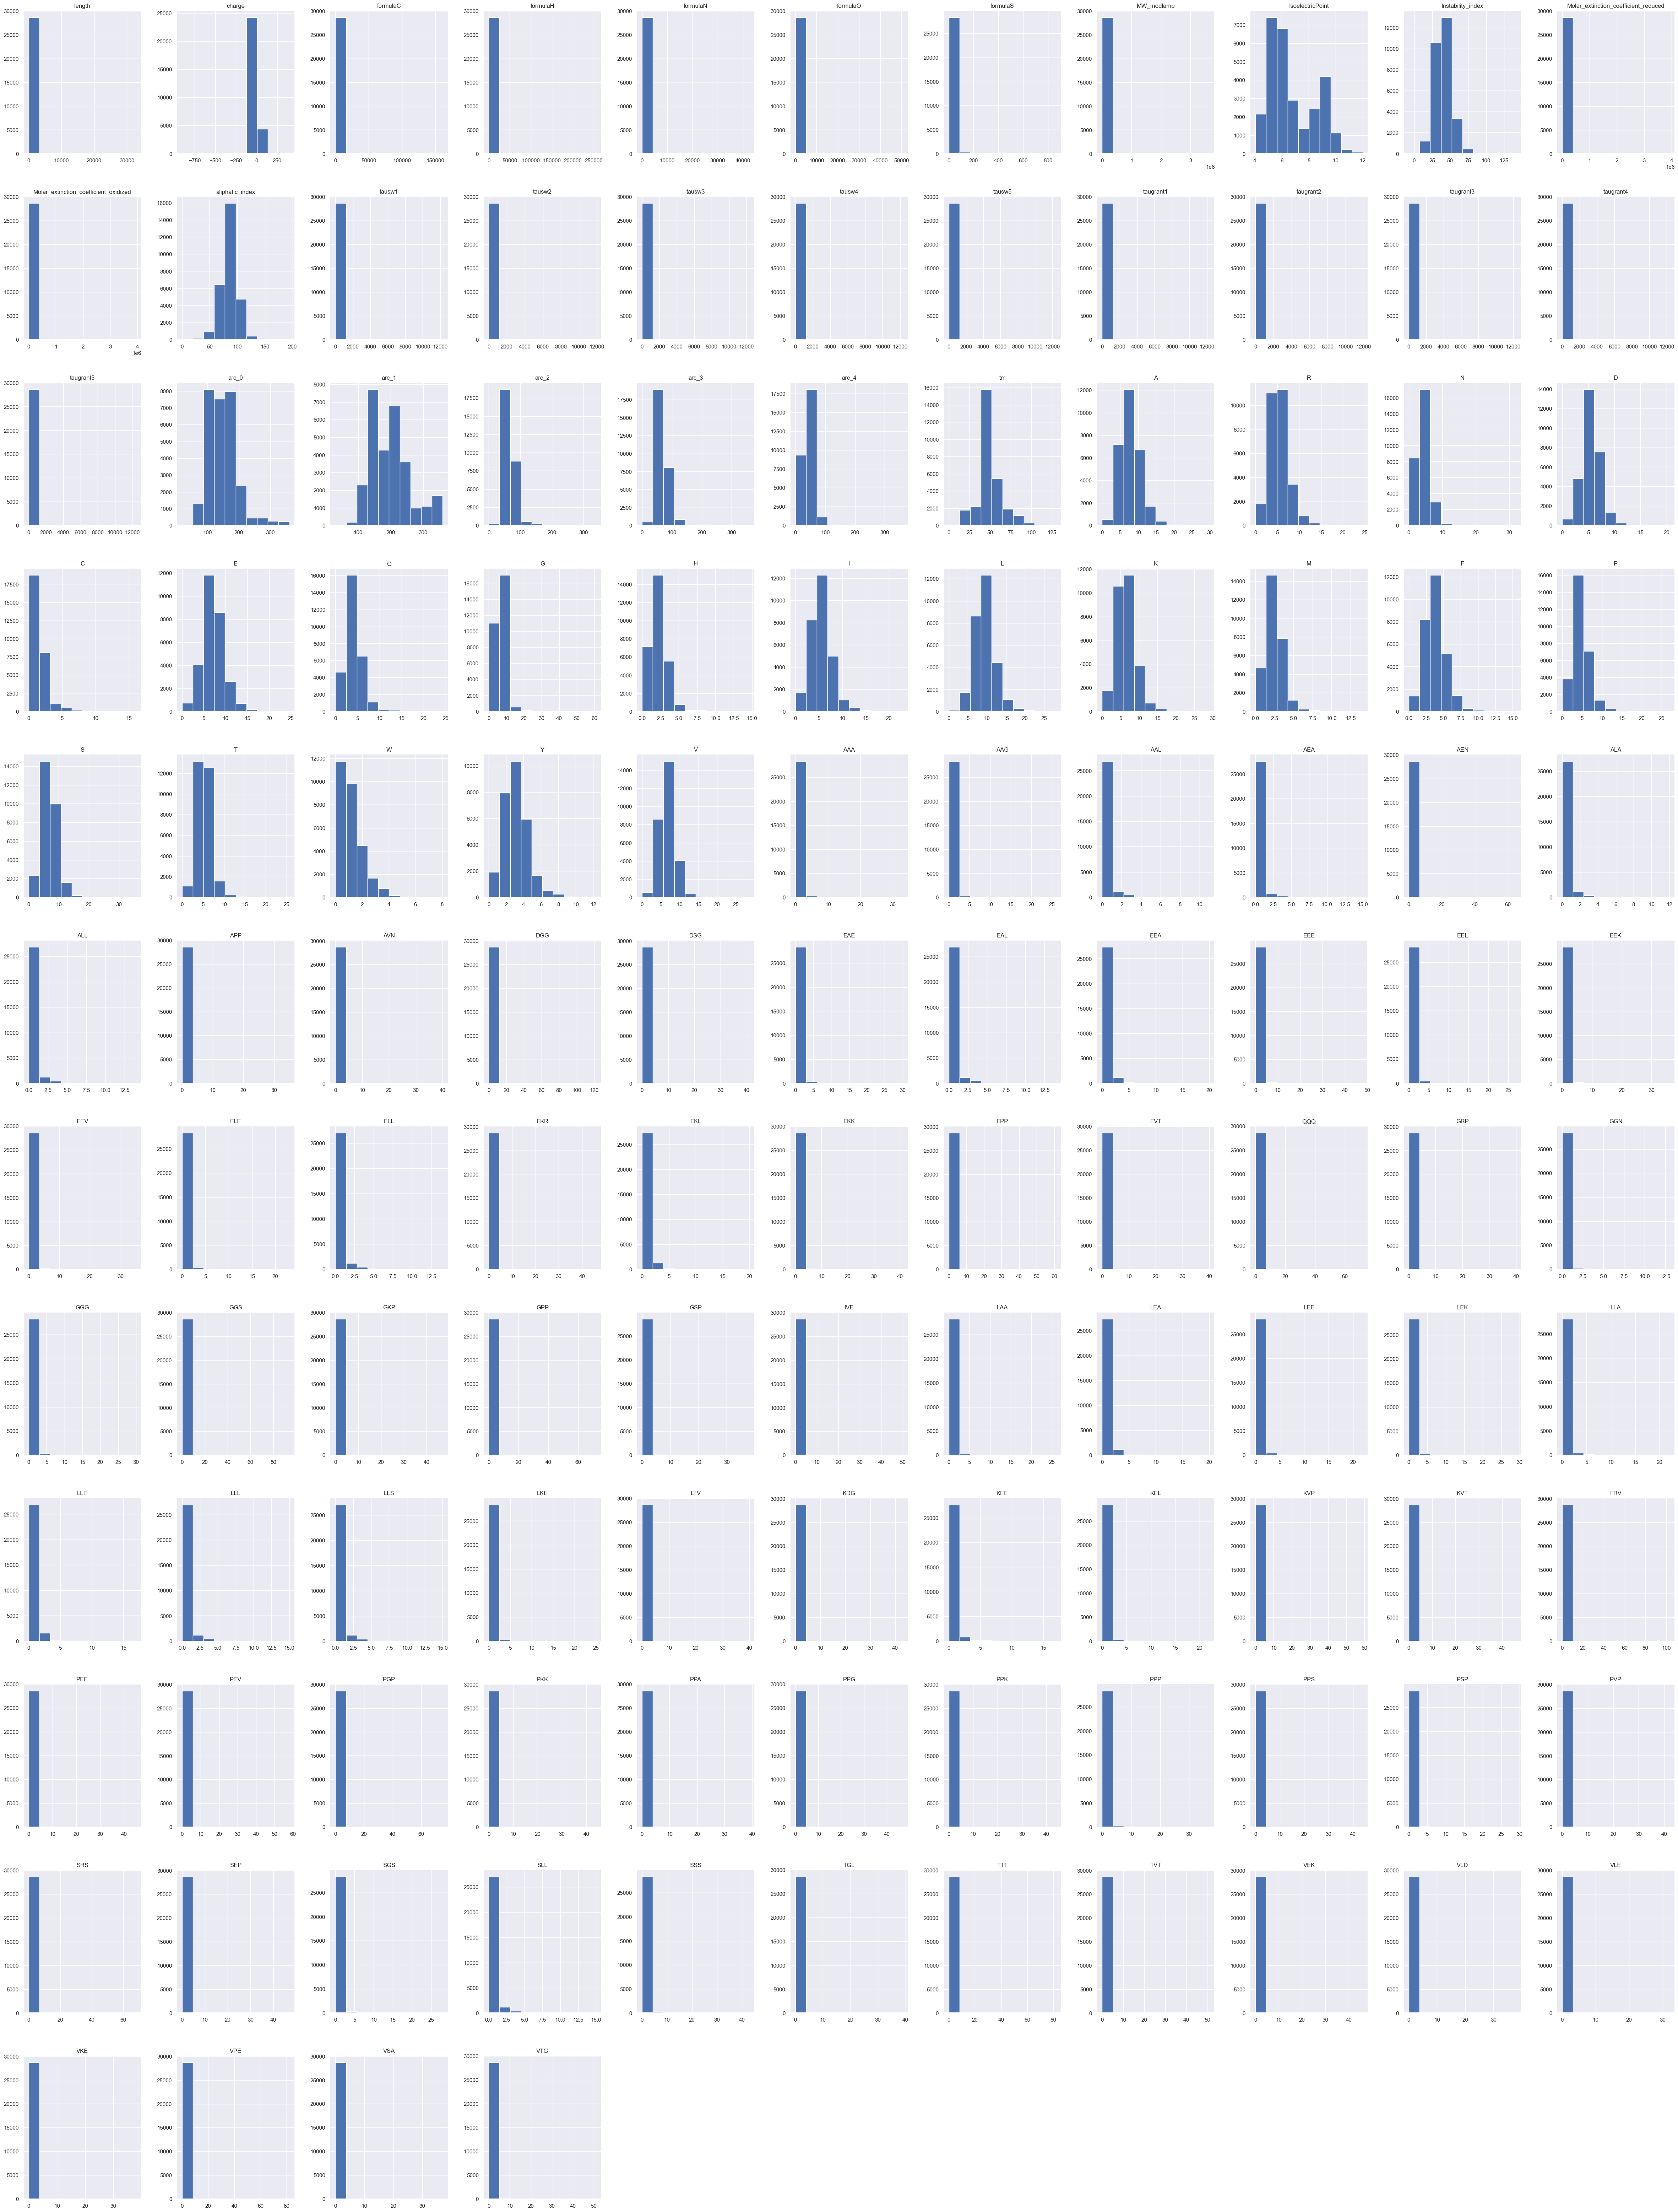

In [12]:
dataset.hist(figsize=(60,80))

Através da análise dos histogramas, visualizamos heterogeneidade nas distribuições das features. Algumas têm distribuições marcadamente assimétricas. Uma vez que pode haver "outliers" a extremar as gamas de valores, efetuámos normalização dos valores para uma escala comum, através de `StandardScaler`.

Antes: (28701, 124) (28701, 1)
Depois: (28344, 124) (28344, 1)


,length,charge,formulaC,formulaH,formulaN,formulaO,formulaS,MW_modlamp,IsoelectricPoint,Instability_index,...,TGL,TTT,TVT,VEK,VLD,VLE,VKE,VPE,VSA,VTG
count,2.834400e+04,2.834400e+04,2.834400e+04,2.834400e+04,2.834400e+04,2.834400e+04,2.834400e+04,2.834400e+04,2.834400e+04,2.834400e+04,...,2.834400e+04,2.834400e+04,2.834400e+04,2.834400e+04,2.834400e+04,2.834400e+04,2.834400e+04,2.834400e+04,2.834400e+04,2.834400e+04
mean,-3.609870e-17,3.283979e-17,5.013708e-17,2.807677e-17,6.016450e-17,-5.414805e-17,1.604387e-17,3.409322e-17,-8.072070e-17,-2.747512e-16,...,1.203290e-17,9.024675e-18,-8.021933e-18,-2.306306e-17,-2.607128e-17,2.807677e-17,-2.005483e-18,2.607128e-17,-4.010967e-18,4.010967e-18
std,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,...,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00
min,-6.989018e-01,-4.622206e+01,-7.013828e-01,-6.956237e-01,-7.034540e-01,-6.911253e-01,-7.807100e-01,-7.011934e-01,-1.595515e+00,-4.218991e+00,...,-2.061504e-01,-1.629976e-01,-1.411789e-01,-2.292767e-01,-2.418305e-01,-3.022593e-01,-2.293890e-01,-1.027481e-01,-2.384005e-01,-1.651595e-01
25%,-3.765513e-01,-2.305957e-01,-3.736235e-01,-3.715248e-01,-3.792904e-01,-3.757608e-01,-4.739183e-01,-3.758607e-01,-7.975086e-01,-6.273649e-01,...,-2.061504e-01,-1.629976e-01,-1.411789e-01,-2.292767e-01,-2.418305e-01,-3.022593e-01,-2.293890e-01,-1.027481e-01,-2.384005e-01,-1.651595e-01
50%,-1.696472e-01,1.040466e-01,-1.690808e-01,-1.683011e-01,-1.731087e-01,-1.773400e-01,-2.109541e-01,-1.726228e-01,-3.569038e-01,-7.153033e-02,...,-2.061504e-01,-1.629976e-01,-1.411789e-01,-2.292767e-01,-2.418305e-01,-3.022593e-01,-2.293890e-01,-1.027481e-01,-2.384005e-01,-1.651595e-01
75%,1.152206e-01,4.351760e-01,1.180922e-01,1.145506e-01,1.155458e-01,1.054336e-01,1.396650e-01,1.128535e-01,9.799262e-01,5.547256e-01,...,-2.061504e-01,-1.629976e-01,-1.411789e-01,-2.292767e-01,-2.418305e-01,-3.022593e-01,-2.293890e-01,-1.027481e-01,-2.384005e-01,-1.651595e-01
max,4.842132e+01,2.069782e+01,4.872398e+01,4.891507e+01,4.809175e+01,4.780024e+01,3.712997e+01,4.830509e+01,3.099382e+00,8.899844e+00,...,5.023253e+01,1.138769e+02,5.509029e+01,5.351695e+01,5.042320e+01,4.413795e+01,5.109352e+01,6.111437e+01,4.969516e+01,5.573399e+01


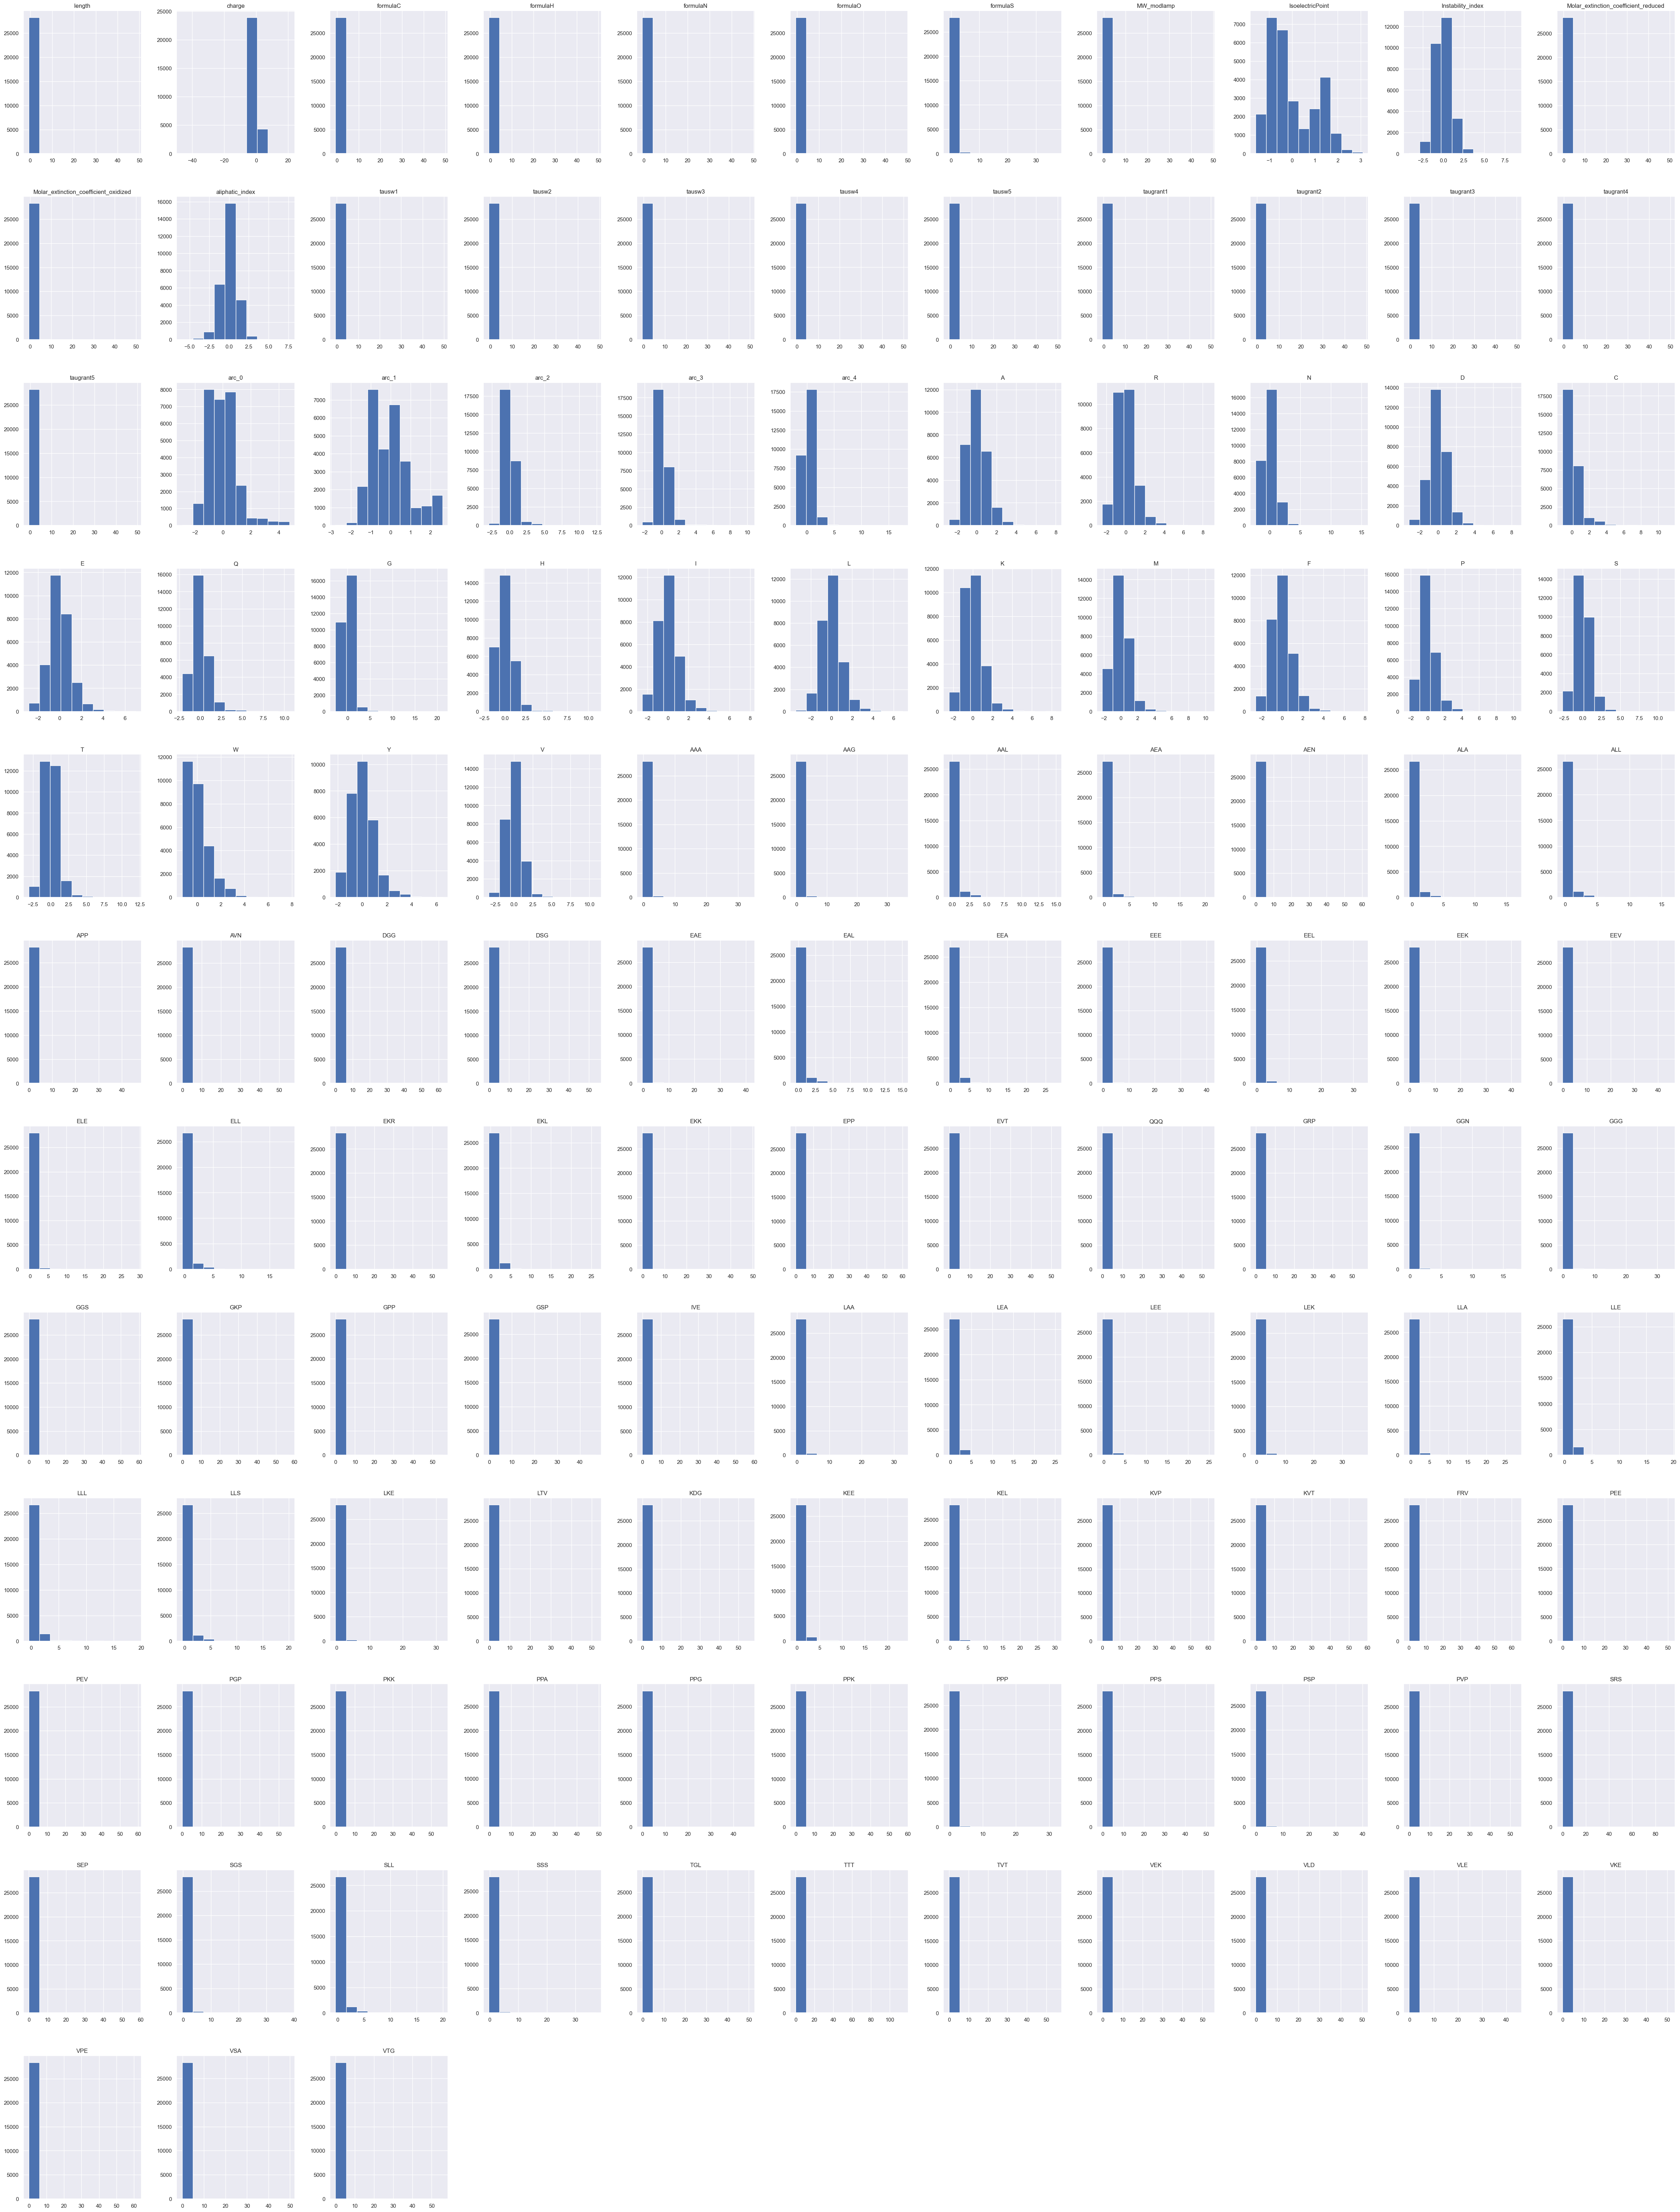

In [13]:
# Separar dados em X e Y para aplicar o scaler apenas às features
Y_dataset = dataset["tm"].to_frame(name = "tm")
X_dataset = dataset.drop("tm", axis=1)
print("Antes:", X_dataset.shape, Y_dataset.shape)

# Remoção de outliers
X_dataset = X_dataset[(np.abs(stats.zscore(dataset["tm"])) < 3)]
Y_dataset = Y_dataset[(np.abs(stats.zscore(dataset["tm"])) < 3)]
print("Depois:", X_dataset.shape, Y_dataset.shape)

# Fazer normalização dos dados de X
data = StandardScaler().fit(X_dataset)
data_st = data.transform(X_dataset)

# Sumariar os dados transformados (atenção que agora é array numpy e não panda dataframe)
np.set_printoptions(precision=3)

# Converter de novo a pandas dataframe 
data_scale = pd.DataFrame(data_st, index=X_dataset.index, columns=X_dataset.columns)

# Sumariar estatísticas
data_scale.hist(figsize=(60,80))
# Resumo de medidas estatísticas depois de estandardização
data_scale.describe()

Confirmamos que as features já têm os valores num epectro mais semelhante, na gama das unidades e centrada em zero.

Avaliámos de seguida as correlações entre as diferentes features do dataset.

,length,charge,formulaC,formulaH,formulaN,formulaO,formulaS,MW_modlamp,IsoelectricPoint,Instability_index,...,TGL,TTT,TVT,VEK,VLD,VLE,VKE,VPE,VSA,VTG
length,1.000000,-0.518369,0.999465,0.999398,0.999350,0.999099,0.905650,0.999739,-0.097443,0.143693,...,0.737628,0.354938,0.770979,0.743495,0.742937,0.711486,0.742882,0.782055,0.736980,0.768369
charge,-0.518369,1.000000,-0.515359,-0.511354,-0.509255,-0.537081,-0.481836,-0.519656,0.590594,-0.048162,...,-0.332061,-0.329175,-0.377712,-0.285312,-0.328447,-0.335497,-0.330454,-0.297564,-0.302517,-0.320104
formulaC,0.999465,-0.515359,1.000000,0.999834,0.999095,0.998336,0.903878,0.999788,-0.096424,0.139884,...,0.738238,0.348670,0.771874,0.747513,0.746805,0.714816,0.745687,0.786089,0.737090,0.770373
formulaH,0.999398,-0.511354,0.999834,1.000000,0.999131,0.998262,0.902028,0.999676,-0.092675,0.139799,...,0.738810,0.347852,0.773440,0.750748,0.749018,0.717316,0.748217,0.788758,0.738938,0.771766
formulaN,0.999350,-0.509255,0.999095,0.999131,1.000000,0.998766,0.905485,0.999565,-0.087873,0.153082,...,0.731753,0.350710,0.764932,0.740908,0.741184,0.710886,0.740002,0.777428,0.731763,0.762596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VLE,0.711486,-0.335497,0.714816,0.717316,0.710886,0.706964,0.596527,0.711938,-0.066994,0.069621,...,0.581246,0.221388,0.642779,0.638333,0.630014,1.000000,0.615376,0.696231,0.594598,0.636889
VKE,0.742882,-0.330454,0.745687,0.748217,0.740002,0.738947,0.608369,0.742418,-0.055148,0.038306,...,0.679716,0.227685,0.737030,0.714657,0.676223,0.615376,1.000000,0.785157,0.684328,0.724849
VPE,0.782055,-0.297564,0.786089,0.788758,0.777428,0.772941,0.614429,0.780234,-0.027476,0.034368,...,0.772171,0.259335,0.852945,0.822335,0.779763,0.696231,0.785157,1.000000,0.769137,0.851268
VSA,0.736980,-0.302517,0.737090,0.738938,0.731763,0.729579,0.610610,0.733764,-0.030817,0.025283,...,0.686408,0.252233,0.729541,0.678896,0.656717,0.594598,0.684328,0.769137,1.000000,0.728771


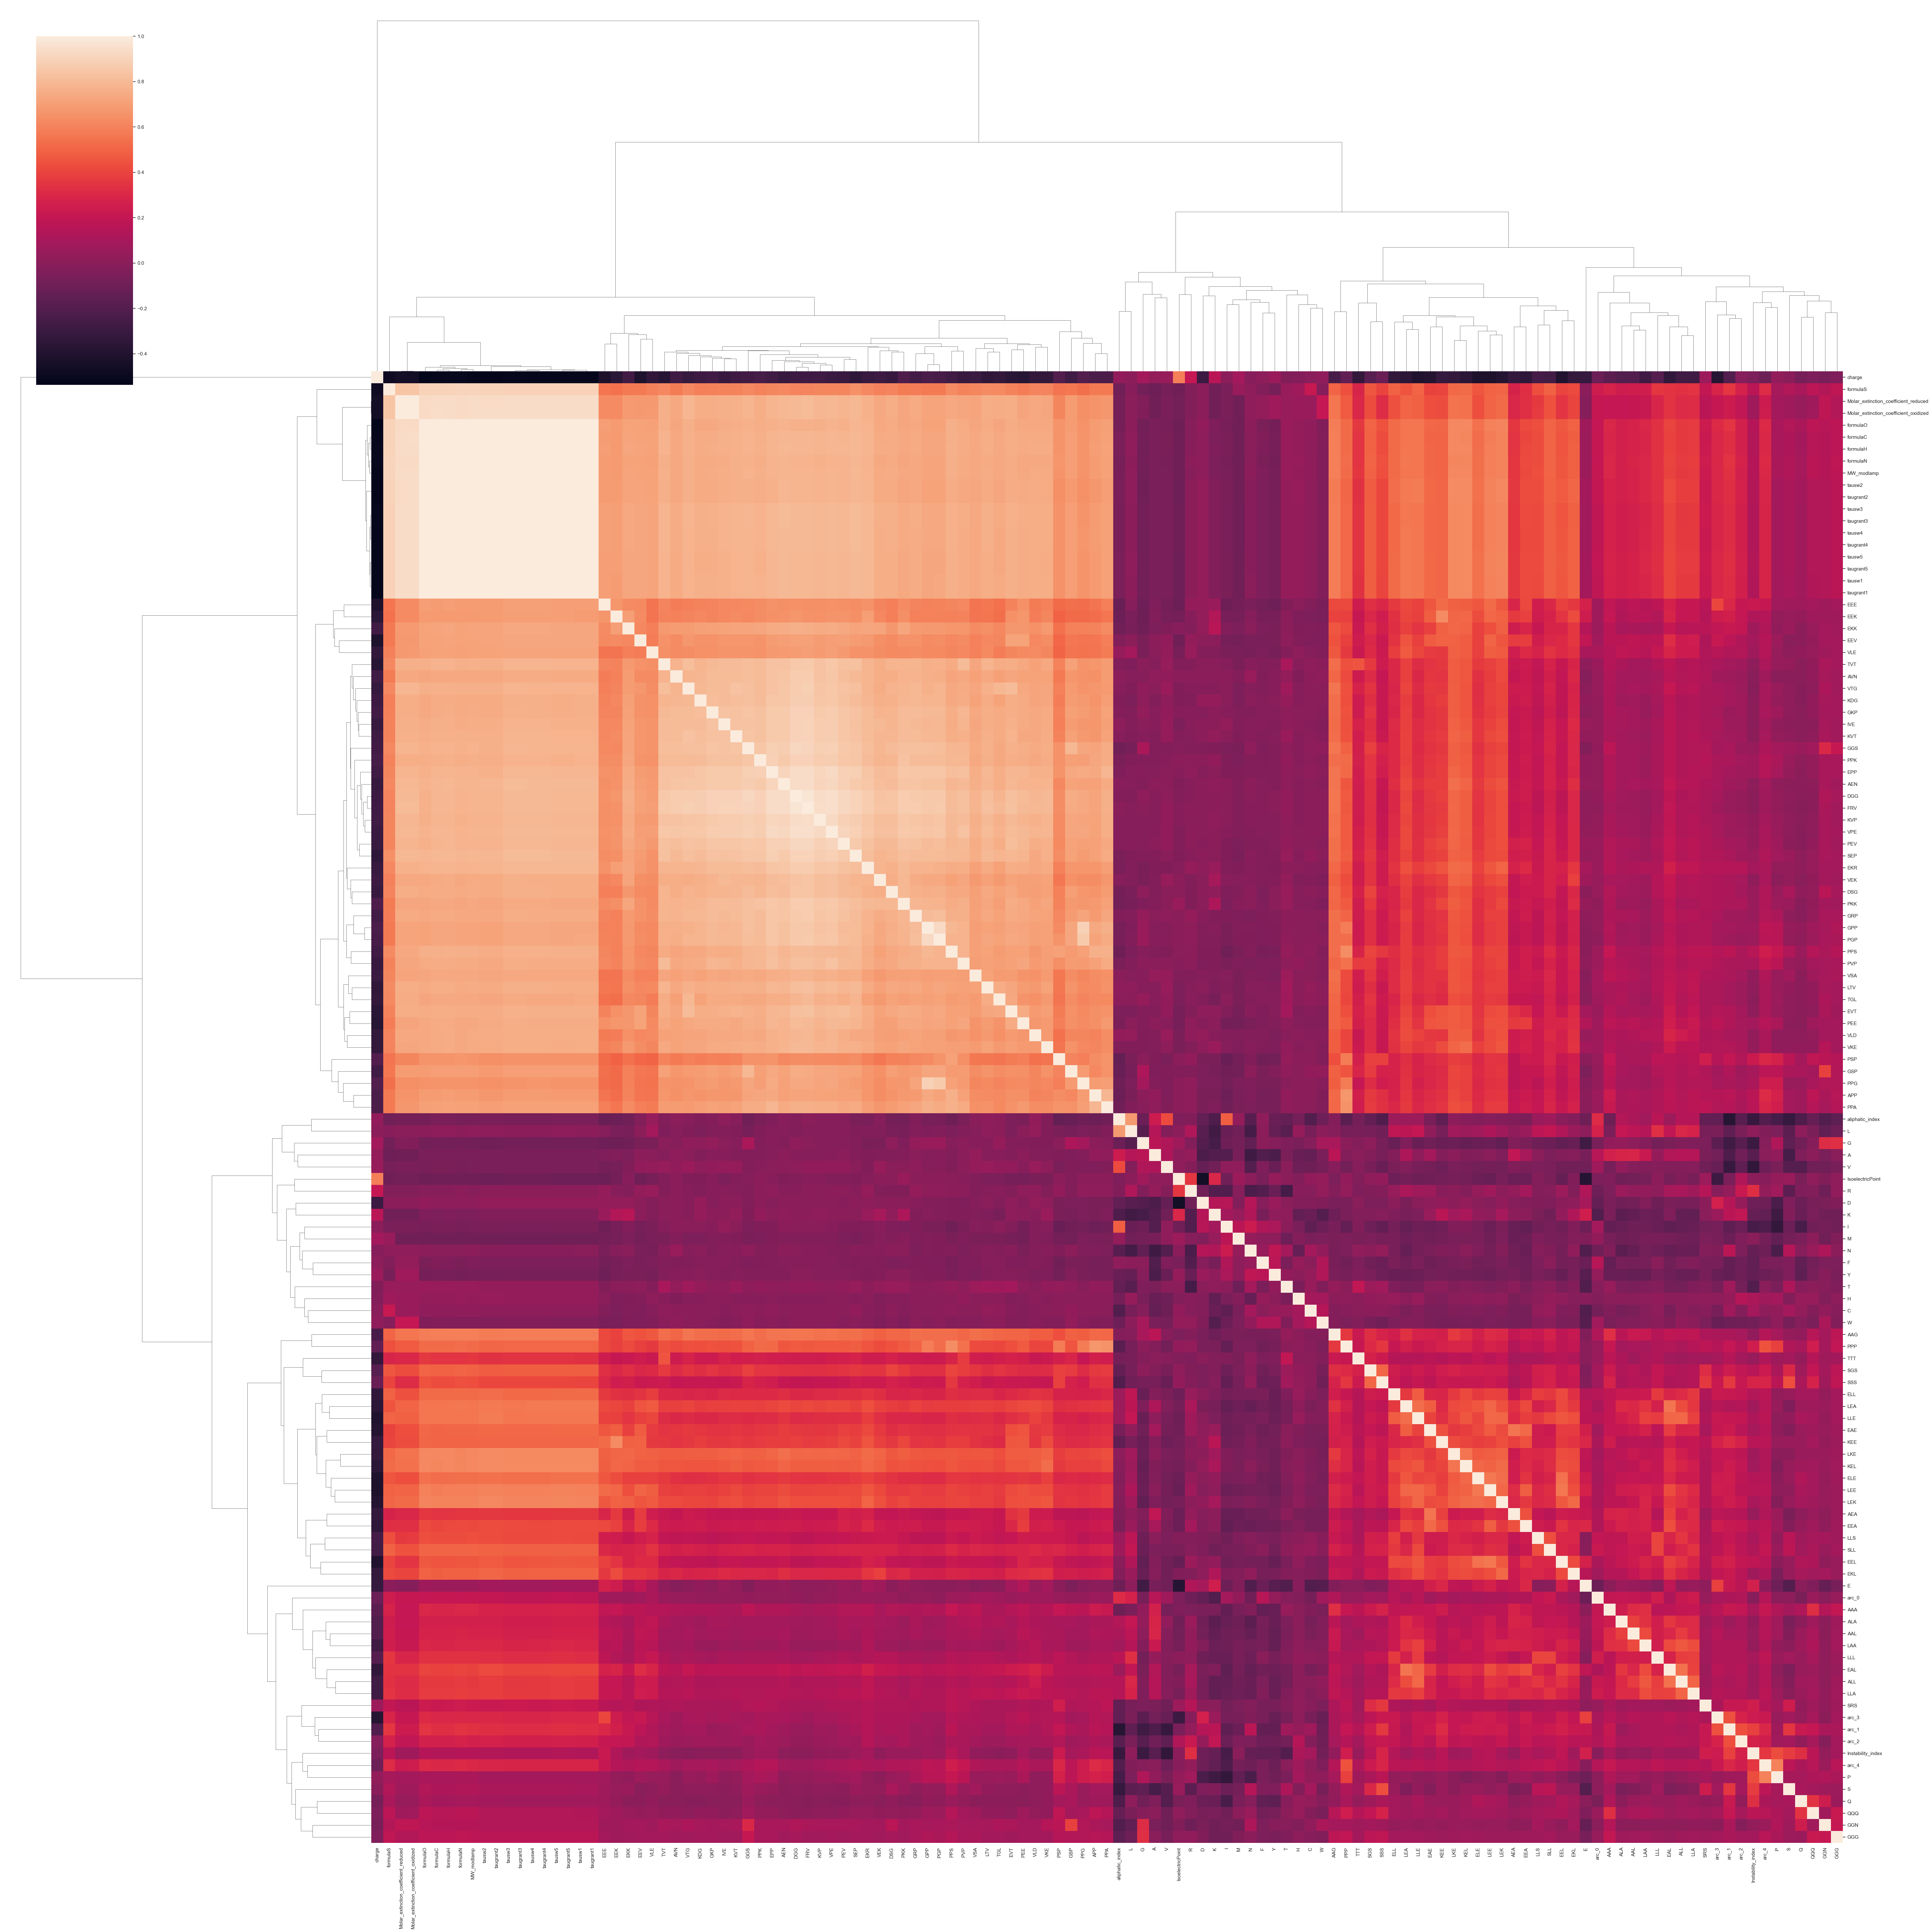

In [14]:
#Estabelecer uma matriz de correlação e visualizá-la em bruto e através de um clustermap
corr_matrix = data_scale.corr()
sn.clustermap(corr_matrix.iloc[1:,1:], figsize=(60,60))
corr_matrix

Ao analisar a matriz de correlação e respetivo clustermap, verificamos que existe um conjunto de features com um alto grau de correlação. A existência de features muito correlacionadas acrescenta pouca informação, aumentando a complexidade do modelo.
Observa-se, por exemplo, uma alta correlação entre as features:
- formulaC, formulaN, formulaO e formulaS, relativas à fórmula química;
- tamanho, carga, e coeficientes de extinção molar;
- os diferentes taus;
o que faz sentido do ponto de vista biológico.

Estas correlações são validadas pelo clustermap, que as agrupou.

Decidimos então eliminar as features com correlação muito elevada (considerando um threshold de 0.8).

In [15]:
# Obtenção das features com correlação muito elevada (de acordo com o threshold = 0.8)
max_corr=0.8
correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > max_corr:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

print(len(correlated_features), correlated_features)

48 {'VEK', 'EPP', 'formulaN', 'taugrant4', 'Molar_extinction_coefficient_oxidized', 'TVT', 'DGG', 'FRV', 'Molar_extinction_coefficient_reduced', 'GRP', 'PEV', 'formulaS', 'formulaH', 'GGS', 'IVE', 'KVT', 'SEP', 'tausw1', 'PEE', 'PPS', 'EKR', 'MW_modlamp', 'LTV', 'taugrant3', 'taugrant2', 'KVP', 'tausw2', 'GKP', 'tausw3', 'formulaO', 'AEN', 'taugrant5', 'PPK', 'VPE', 'VTG', 'tausw4', 'DSG', 'formulaC', 'GPP', 'tausw5', 'KDG', 'PPG', 'EVT', 'PVP', 'taugrant1', 'PKK', 'AVN', 'PGP'}


Dado o baixo valor informativo destas 48 features causada pela alta correlação, decidimos retira-las da análise seguinte de maneira a obter melhores resultados. Recalculando as correlações sem estas colunas obtemos um subconjunto de features com maior qualidade.

In [16]:
# Eliminar features com correlação muito elevada
data_scale.drop(labels = correlated_features, axis = 1, inplace = True)

,length,charge,IsoelectricPoint,Instability_index,aliphatic_index,arc_0,arc_1,arc_2,arc_3,arc_4,...,SRS,SGS,SLL,SSS,TGL,TTT,VLD,VLE,VKE,VSA
length,1.000000,-0.518369,-0.097443,0.143693,-0.064556,0.209643,0.331447,0.262532,0.294446,0.305916,...,0.229342,0.499670,0.499706,0.437530,0.737628,0.354938,0.742937,0.711486,0.742882,0.736980
charge,-0.518369,1.000000,0.590594,-0.048162,0.023644,-0.113028,-0.207167,-0.019073,-0.379447,-0.104908,...,0.062690,-0.183567,-0.262708,-0.122159,-0.332061,-0.329175,-0.328447,-0.335497,-0.330454,-0.302517
IsoelectricPoint,-0.097443,0.590594,1.000000,0.003683,-0.043407,-0.045331,-0.056795,0.127884,-0.292194,-0.012470,...,0.062726,0.017255,-0.055659,0.025838,-0.045540,-0.028315,-0.050989,-0.066994,-0.055148,-0.030817
Instability_index,0.143693,-0.048162,0.003683,1.000000,-0.311332,-0.010643,0.387273,0.267914,0.236658,0.355384,...,0.255000,0.157208,0.131841,0.280226,0.003639,0.049631,0.031876,0.069621,0.038306,0.025283
aliphatic_index,-0.064556,0.023644,-0.043407,-0.311332,1.000000,0.311122,-0.378746,-0.185869,-0.148373,-0.201375,...,-0.144361,-0.144148,0.067228,-0.216458,0.003868,-0.077339,0.022101,0.041532,-0.038216,-0.004514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTT,0.354938,-0.329175,-0.028315,0.049631,-0.077339,0.052183,0.147647,0.081867,0.093963,0.126553,...,0.075460,0.269877,0.146380,0.230138,0.260839,1.000000,0.214736,0.221388,0.227685,0.252233
VLD,0.742937,-0.328447,-0.050989,0.031876,0.022101,0.075184,0.104419,0.098189,0.133603,0.112644,...,0.117936,0.313908,0.303665,0.213480,0.649520,0.214736,1.000000,0.630014,0.676223,0.656717
VLE,0.711486,-0.335497,-0.066994,0.069621,0.041532,0.106197,0.130708,0.138636,0.158958,0.142648,...,0.128437,0.305236,0.339932,0.225898,0.581246,0.221388,0.630014,1.000000,0.615376,0.594598
VKE,0.742882,-0.330454,-0.055148,0.038306,-0.038216,0.068436,0.138878,0.116960,0.140842,0.108993,...,0.132090,0.316241,0.287723,0.213098,0.679716,0.227685,0.676223,0.615376,1.000000,0.684328


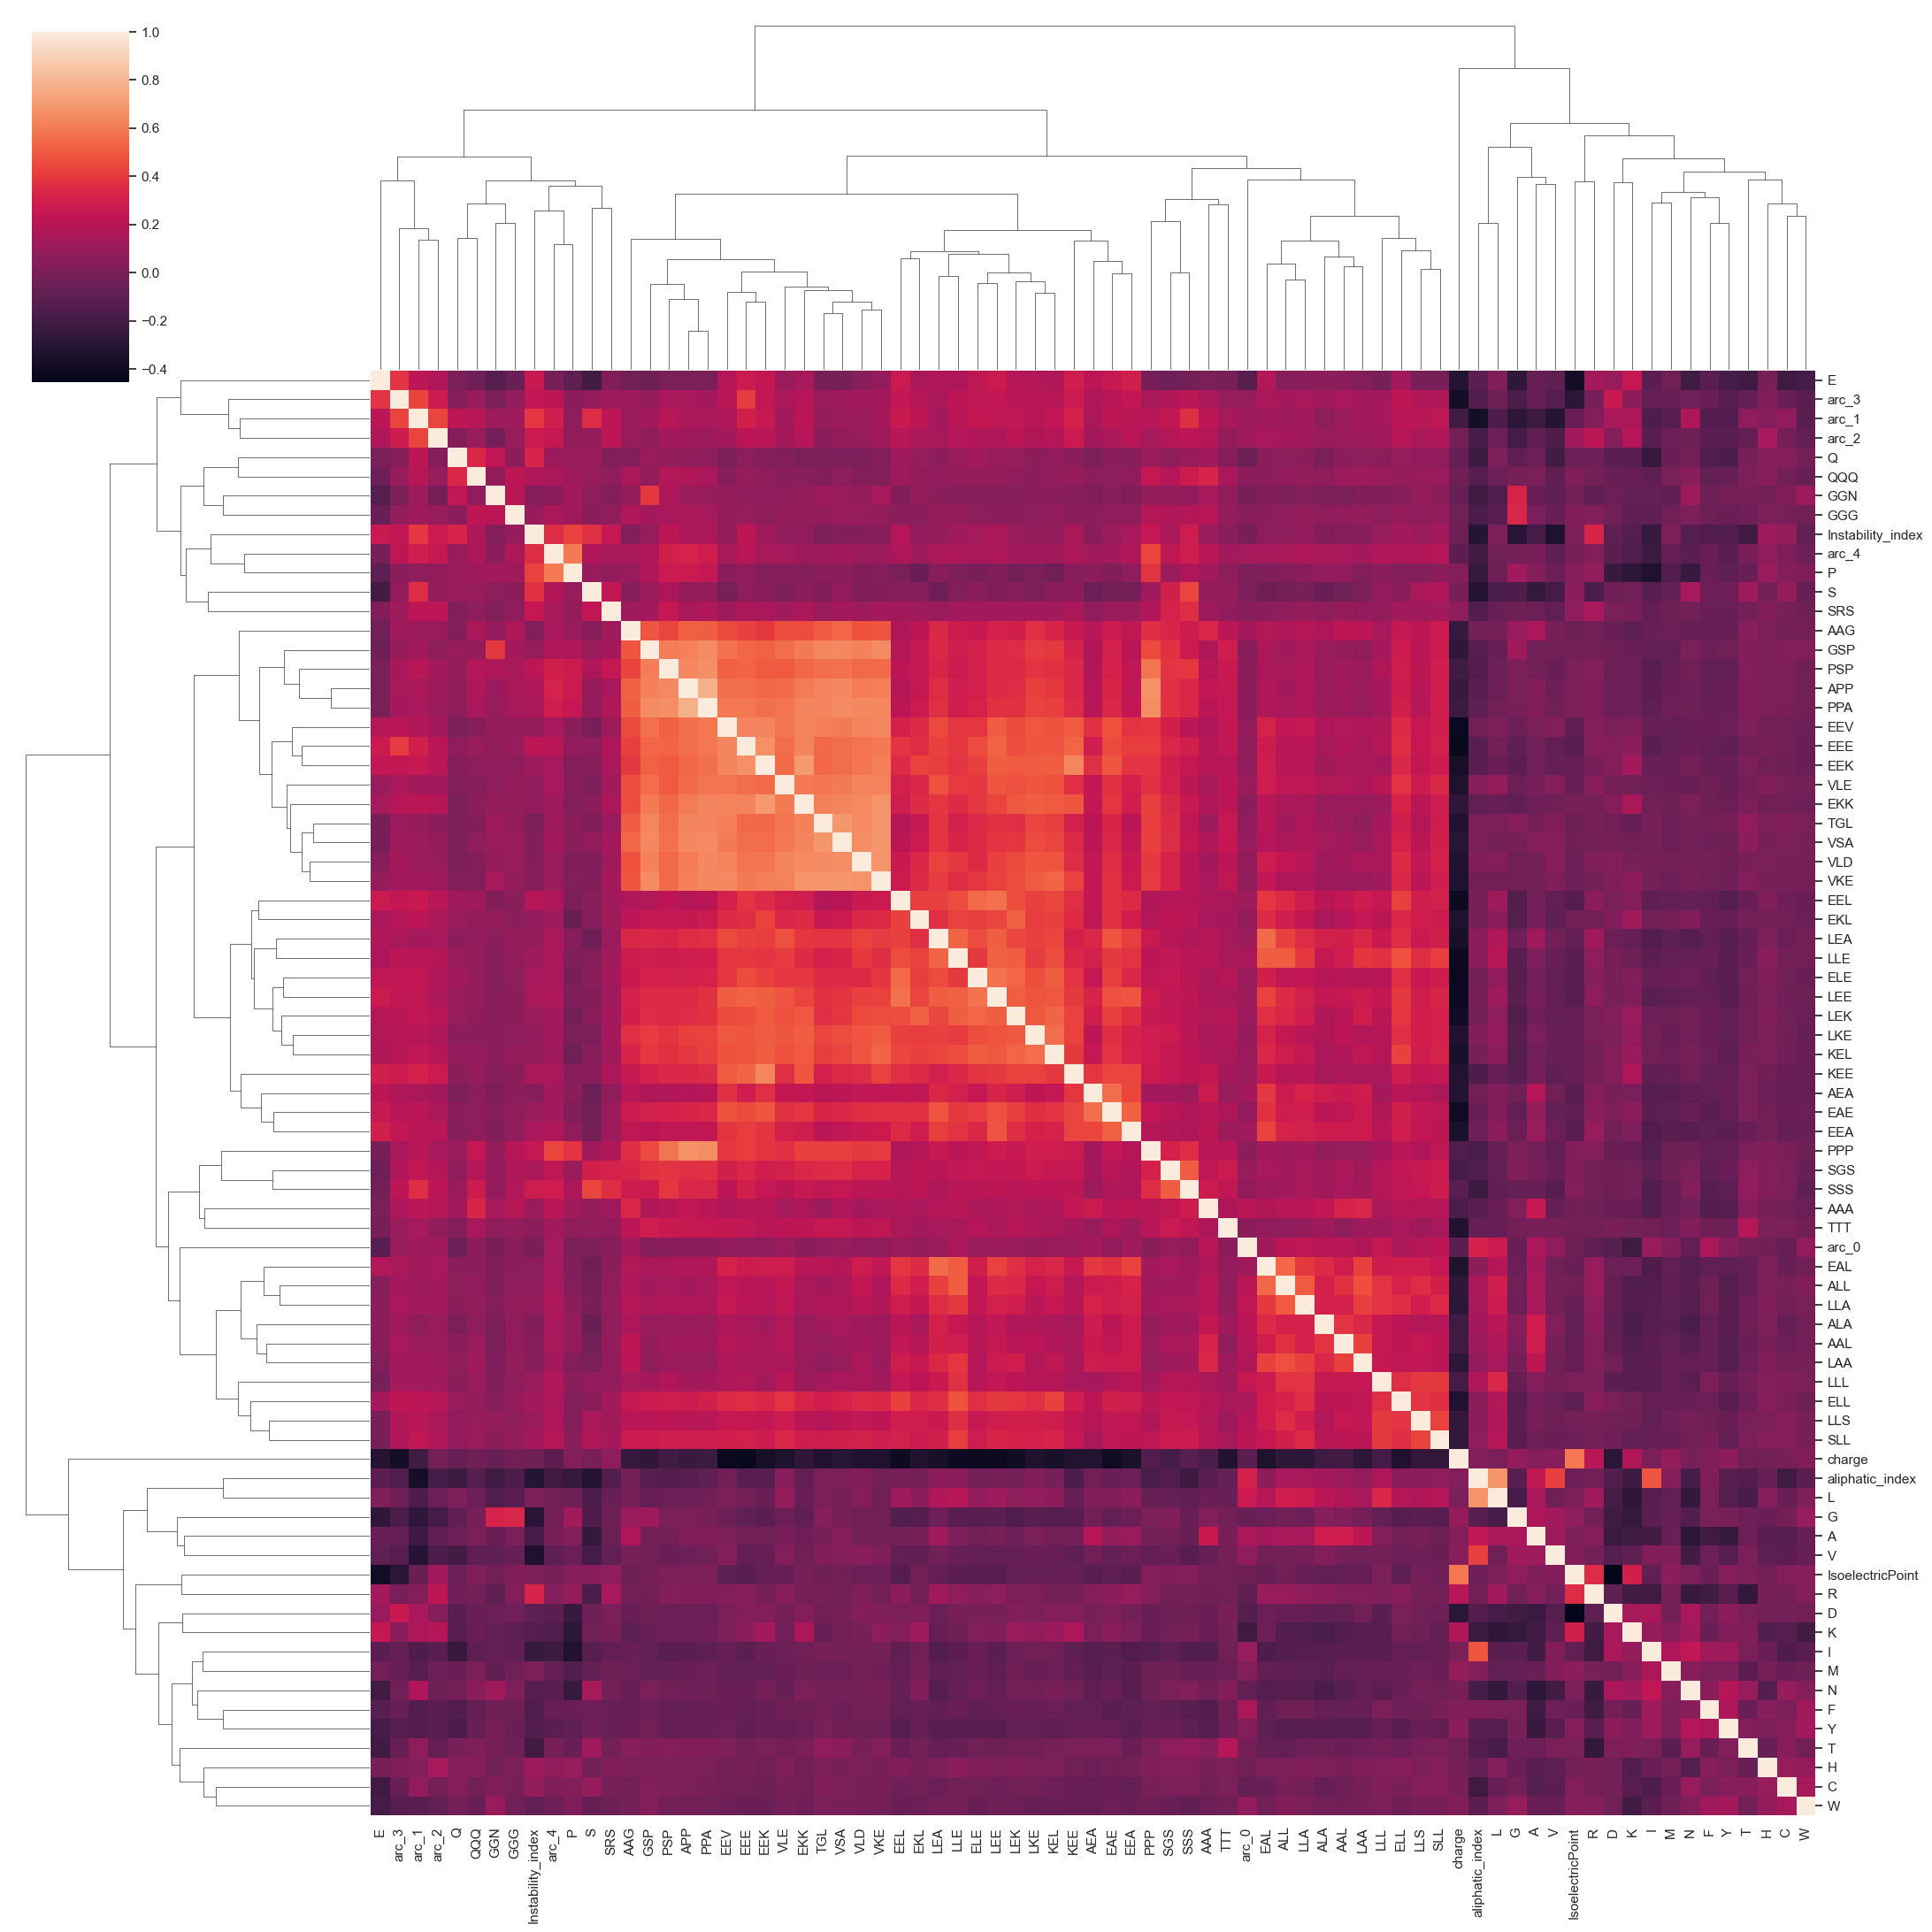

In [17]:
# Efetuar nova matriz de correlação e clustermap depois da eliminação de features muito correlacionadas
corr_matrix = data_scale.corr()
sn.clustermap(corr_matrix.iloc[1:,1:], figsize=(22,22))
corr_matrix

Caracterizámos ainda o Y - variável `tm`, de forma a visualizar a distribuição dos dados.

                 tm
count  28344.000000
mean      48.955250
std       12.847299
min        9.800000
25%       42.300000
50%       47.900000
75%       53.300000
max       90.500000


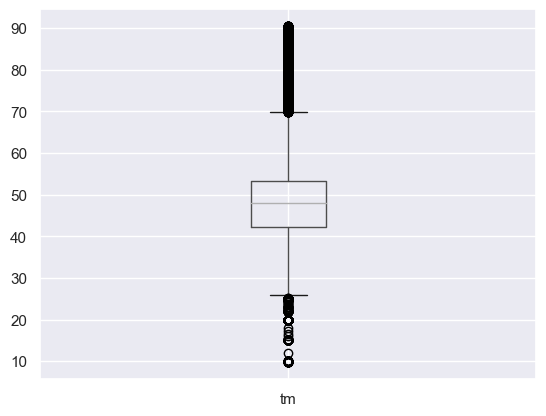

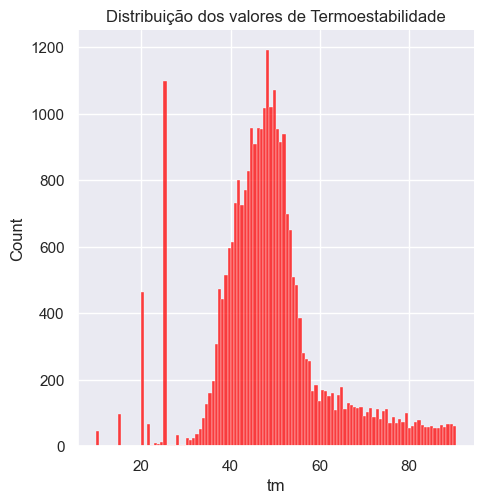

In [18]:
#Sumário de medidas estatísticas para Y (variável "tm")
summary = Y_dataset.describe()
print(summary)

#Visualização dos dados de Y (variável "tm") através de um boxplot
Y_dataset.boxplot()

sn.displot(data = Y_dataset, x = 'tm', color = 'red')
plt.xlabel('tm')
plt.title('Distribuição dos valores de Termoestabilidade')
plt.show()

 Verificámos que há uma distribuição assimétrica, com alguns "outliers". A região de valores mais comuns pertence ao intervalo entre `tm=30` e, aproximadamente, `tm=65`.

In [19]:
# Guardar dados processados num ficheiro para facilitar o reprocessamento.
to_export = pd.concat([data_scale, Y_dataset],axis=1, ignore_index=False)
to_export.to_csv('datasets/all_descriptors_processed.csv')

---
## Análise não supervisionada

Depois do pré-processamento dos dados, procedemos à análise através de métodos não supervisionados, permitindo visualizar e perceber melhor as características do nosso dataset.


De seguida, tentámos perceber se seria possível, de certa forma, agrupar os dados do Y (variável "tm") em "clusters", convertendo a variável contínua numa variável categórica.
Assim, efetuamos clustering hierárquico para visualizar o número de categorias que eventualmente poderiam ser definidas.


In [3]:
dataset = pd.read_csv('datasets/all_descriptors_processed.csv', delimiter = ',')

Y = dataset["tm"].to_frame(name = "tm")
X = dataset.drop("tm", axis=1)

In [20]:
# Criar linkage matrix e fazer dendograma, incluindo as contagens de amostras para cada nodo
def linkage_matrix(model):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    return linkage_matrix


# Distance_threshold=0 assegura computação da árvore inteira
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X)
matrix = linkage_matrix(model)

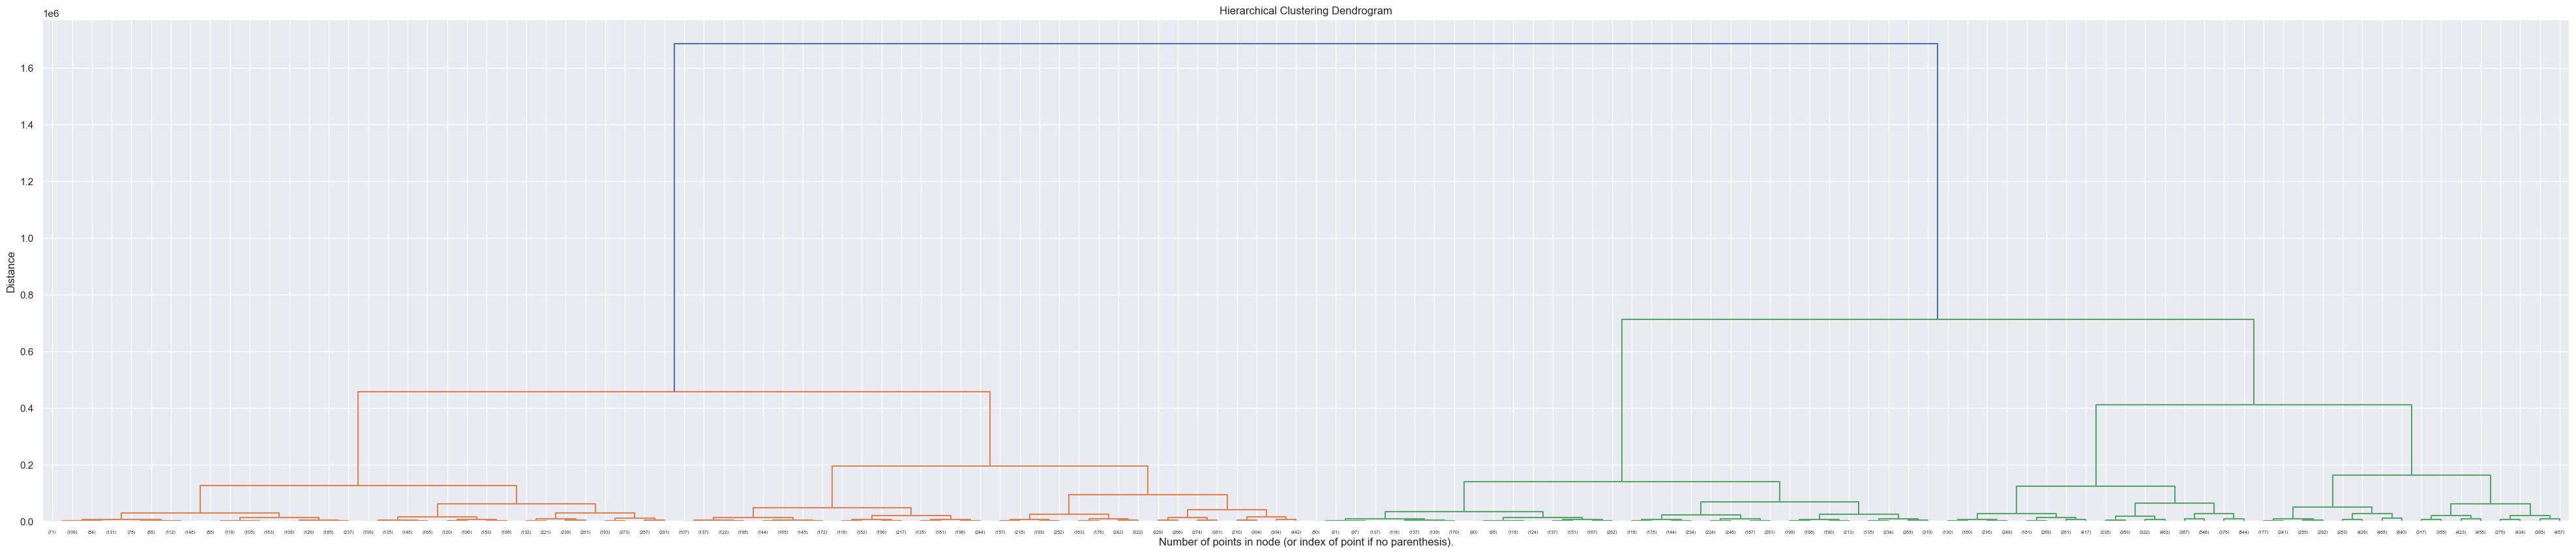

In [21]:
#Efetuar o gráfico de clustering
plt.figure(figsize=(50,10))
plt.title("Hierarchical Clustering Dendrogram")
dendrogram(matrix, truncate_mode="level", p=6, leaf_rotation=0)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel('Distance')
plt.show()

Ao visualizar o dendograma, constatamos que, para um corte correspondendo a distâncias inferiores a 0.5, um número de sete clusters parece ser adequado.

### Clustering aglomerativo

De seguida, efetuamos análise do clustering aglomerativo, tendo em conta as inferências obtidas no dendograma anterior. Considerámos um número de clusters igual a 7.

Desta forma, vamos explorar a possibilidade de prever o `tm` em formato categórico e verificar se os clusters gerados têm boa separação das categorias.

In [5]:
# Copiar a variável Y para criar nova variável categórica
Y_categorical = Y.copy()

# Para criar a nova variável categórica, pretendemos sete categorias, pelo que dividimos em sete o intervalo de valores da variável "tm"
min = 9.8
max = 90.5
step = (max-min)/7
bins = [min + i*step for i in range(7)]
bins.append(np.inf)
print(bins) 

# Criação da nova variável categórica, atribuindo labels apropriados
labels = [
    "muito baixo",
    "baixo",
    "baixo-médio",
    "médio",
    "médio-alto",
    "alto",
    "muito alto"
]
Y_categorical = pd.cut(Y_categorical['tm'], bins, labels=labels).to_frame(name = "tm")

[9.8, 21.32857142857143, 32.85714285714286, 44.385714285714286, 55.91428571428571, 67.44285714285714, 78.97142857142858, inf]


In [6]:
# Verificar o número de amostras por cada categoria da nova variável categórica
Y_categorical["tm"].value_counts()

médio          13626
baixo-médio     7428
médio-alto      2739
alto            1545
baixo           1358
muito alto      1036
muito baixo      611
Name: tm, dtype: int64

In [24]:
# Clustering aglomerativo considerando sete clusters
hclust = AgglomerativeClustering(n_clusters=7, affinity="euclidean", linkage="ward")
hclust.fit(X)
res_hc = hclust.labels_
pd.crosstab(Y_categorical["tm"], res_hc)

col_0,0,1,2,3,4,5,6
tm,,,,,,,
muito baixo,5,22,44,9,516,15,0
baixo,171,171,76,275,512,79,74
baixo-médio,1551,1199,973,1093,1139,753,720
médio,2837,2891,1538,1892,1831,1437,1200
médio-alto,423,544,223,349,538,195,467
alto,257,144,149,303,386,103,203
muito alto,212,135,111,212,170,75,121


Através da análise do clustering aglomerativo, observamos que os sete "clusters" permitem de certa forma efetuar um certo grau de distinção entre categorias. No entanto, verifica-se alguma sobreposição entre categorias, sobretudo em relação às categorias baixo-médio, médio e médio-alto.


Considerámos, então, a análise de clustering aglomerativo com apenas três clusters.

In [25]:
data_Y_categorical = Y_categorical
# Clustering aglomerativo com três clusters
hclust = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
hclust.fit(X)
res_hc = hclust.labels_
pd.crosstab(data_Y_categorical["tm"], res_hc)

col_0,0,1,2
tm,,,
muito baixo,46,560,5
baixo,525,662,171
baixo-médio,3045,2832,1551
médio,6220,4569,2837
médio-alto,1088,1228,423
alto,550,738,257
muito alto,422,402,212


Ao efetuar análise de clustering aglomerativo com três clusters, verificamos uma maior sobreposição entre categorias, não permitindo a sua distinção.

De seguida foi então efetuado clustering K-Means, inicialmente considerando sete clusters.

In [26]:
#Clustering Kmeans
k= 7
kmeans_dataset = KMeans(n_clusters=k, max_iter=1000)
kmeans_dataset.fit(X)
kmeans_dataset.predict(X)

labels = kmeans_dataset.labels_
print(labels)

centroids = kmeans_dataset.cluster_centers_
print(centroids)

pd.crosstab(labels,data_Y_categorical["tm"], rownames=['clusters'] )

[1 1 1 ... 3 3 3]
[[ 1.837e+04 -7.748e-02  9.089e-02  3.867e-02 -1.071e-01  1.392e-01
  -4.740e-02 -6.361e-02 -5.425e-02 -8.917e-02 -9.250e-02  8.301e-02
   1.634e-01  1.034e-01  2.373e-02 -4.263e-02 -5.211e-02  2.203e-03
  -1.393e-03  1.056e-02  1.281e-01  8.639e-02 -9.968e-02  1.326e-01
  -1.042e-01 -9.581e-02 -1.800e-01 -7.338e-02  1.490e-03 -1.611e-02
  -4.096e-02 -3.507e-02 -6.112e-02 -1.829e-03 -5.019e-02  2.451e-02
  -8.171e-02 -2.104e-02  1.972e-02 -6.514e-02 -2.895e-02 -1.533e-02
  -7.426e-02 -8.882e-02 -3.178e-02  1.094e-02 -5.750e-02  3.196e-02
  -5.516e-02  1.492e-02 -5.859e-02 -5.028e-02 -4.420e-02 -2.359e-02
  -6.820e-02 -6.741e-02 -6.783e-02 -9.771e-02 -4.951e-02 -5.942e-02
  -1.008e-01 -6.231e-02 -4.685e-02 -5.831e-02 -2.586e-02 -1.458e-02
  -3.718e-02 -2.014e-02 -5.852e-03 -5.317e-02 -3.423e-02 -1.591e-03
  -1.945e-02 -3.986e-02 -4.995e-02 -5.555e-02 -2.561e-02]
 [ 2.035e+03 -1.008e-02 -5.155e-02 -5.237e-02  2.422e-02 -1.116e-01
   1.419e-01  1.323e-02 -6.849e-02 -2.21

tm,muito baixo,baixo,baixo-médio,médio,médio-alto,alto,muito alto
clusters,,,,,,,
0,34,207,981,1637,648,336,194
1,11,131,935,2317,450,102,101
2,9,366,1044,1786,339,300,200
3,2,69,1115,2103,340,233,182
4,26,119,1110,2180,314,173,126
5,512,313,911,1471,371,301,156
6,17,153,1332,2132,277,100,77


Os resultados foram sobreponíveis aos descritos anteriormente, verificando-se sobreposição entre categorias.

Foi então efetuado clustering K-Means, desta vez considerando três clusters.


In [27]:
k=3
kmeans_dataset = KMeans(n_clusters=k, max_iter=1000)
kmeans_dataset.fit(X)
kmeans_dataset.predict(X)

labels = kmeans_dataset.labels_
print(labels)

centroids = kmeans_dataset.cluster_centers_
print(centroids)

pd.crosstab(labels,data_Y_categorical["tm"], rownames=['clusters'] )

[1 1 1 ... 0 0 0]
[[ 2.392e+04  3.426e-02 -1.943e-02 -6.352e-02  2.288e-03  1.714e-03
   9.654e-03  1.468e-02  1.370e-02  2.007e-02 -1.223e-02 -8.679e-02
   1.071e-02  9.965e-03  5.685e-02 -3.379e-02  2.576e-02  3.366e-03
  -1.981e-02  3.321e-02  1.722e-02 -1.257e-02 -1.710e-02 -3.942e-02
   3.021e-02 -5.716e-03  2.485e-02  3.428e-02  2.118e-03 -5.170e-02
   4.265e-02 -5.078e-03 -6.063e-03 -2.915e-02 -1.313e-02  1.236e-03
   1.977e-03  1.325e-02  1.228e-03 -4.083e-02 -1.521e-03  2.868e-03
   1.078e-02  1.933e-02  1.068e-02  1.991e-02  2.343e-02 -3.501e-02
   5.372e-02 -4.577e-04 -2.721e-02  9.130e-03  1.628e-03  2.150e-02
   5.187e-03  7.642e-03  4.561e-02  3.145e-04  2.816e-02 -2.698e-02
  -3.423e-02  1.117e-02  1.182e-02  2.699e-02  1.925e-02  9.417e-03
   1.660e-02  1.778e-02  4.722e-04  2.552e-02 -1.095e-02  5.225e-03
   2.612e-02  3.098e-02  2.934e-02  2.527e-02  1.505e-02]
 [ 4.759e+03  3.562e-02 -6.175e-02 -6.433e-02  1.117e-01 -5.832e-02
   7.963e-02  6.741e-02  5.117e-02  5.13

tm,muito baixo,baixo,baixo-médio,médio,médio-alto,alto,muito alto
clusters,,,,,,,
0,49,280,2712,4710,762,487,393
1,44,343,2332,5142,900,379,321
2,518,735,2384,3774,1077,679,322


Mais uma vez, os resultados são sobreponíveis à análise de clustering anterior.

---
# PCA
Inicialmente, fizemos a análise considerando sete componentes principais gerados por PCA.


Var. explicada: [1.000e+00 2.430e-07 6.829e-08 5.761e-08 5.169e-08 3.605e-08 3.300e-08]
Soma: 99.9999383506437 %



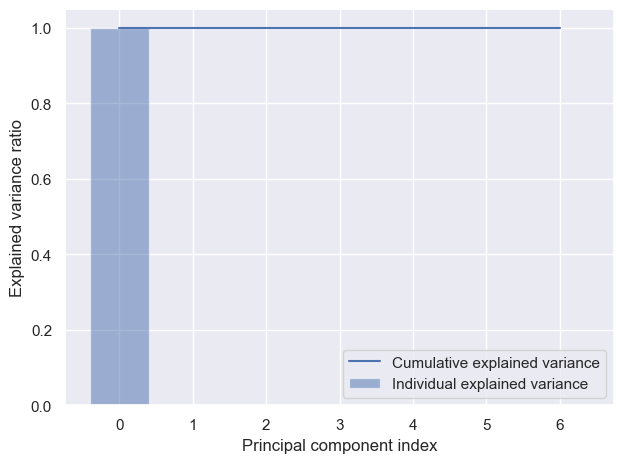

In [28]:
pca = PCA(n_components=7)
pca.fit(X)

X_r = pca.transform(X) # transformacao dos dados no novo espaço utilizando apenas n CP

print('Var. explicada: %s'% str(pca.explained_variance_ratio_))
print('Soma:', sum(pca.explained_variance_ratio_) * 100, "%")

print()

exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Verificamos que, com sete componentes principais, é explicada 99.9% da variabilidade dos dados.

Um maior número de componentes principais conduz a uma maior soma cumulativa das variâncias explicadas, no entanto, poderá trazer complexidade ao modelo. Se for atingida uma soma cumulativa das variâncias explicadas adequada (como, por exemplo, 95%), poderão ser usadas apenas esses componentes nas análises seguintes e, num processo iterativo, verificar se conduzem à otenção de resultados mais favoráveis, com a redução da dimensionalidade do dataset.

Assim, fizemos novamente a análise considerando um número inferior de componentes principais: três.


Var. explicada: [1.000e+00 2.430e-07 6.829e-08]
Soma: 99.9999205155047 %


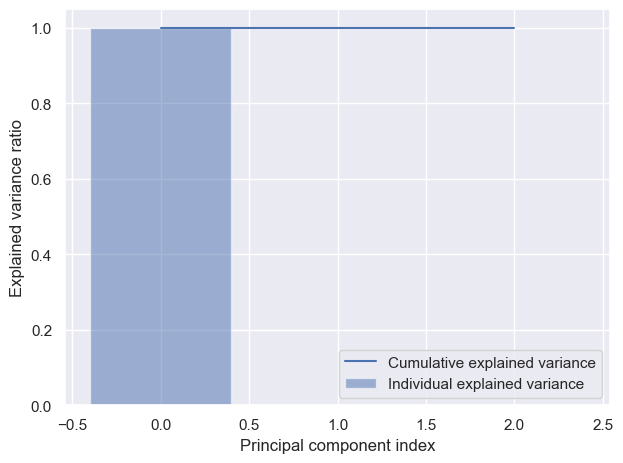

In [29]:
pca = PCA(n_components=3)
pca.fit(X)

# Transformacao dos dados no novo espaço utilizando apenas n CP
X_r = pca.transform(X)
print('Var. explicada: %s'% str(pca.explained_variance_ratio_))
print('Soma:', sum(pca.explained_variance_ratio_) * 100, "%")

exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Considerando três componentes principais, é explicada cerca de 99.9% da variabilidade do dataset, ou seja, um valor sobreponível ao detetado para sete componentes principais.

Ao contrário das nossas expetativas, não se verificou, no entanto, uma diminuição da soma das variâncias esperadas ao reduzir o número de componentes principais.  Atribuimos este resultado ao facto de, em ambos os casos, o primeiro componente principal conseguir explicar a quase totalidade do valor da variância esperado.

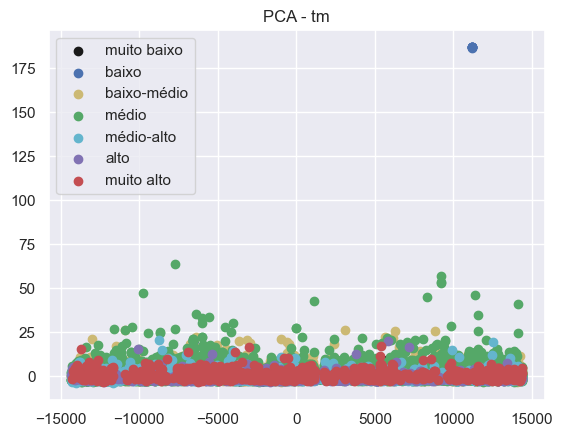

In [30]:
meta_values = data_Y_categorical["tm"]
plt.figure()
for c, name in zip("kbygcmr", ['muito baixo','baixo','baixo-médio','médio','médio-alto','alto','muito alto']):
    plt.scatter(X_r[meta_values == name, 0], X_r[meta_values == name, 1], c=c, label=name)
plt.legend()
plt.title('PCA - tm')
plt.show()


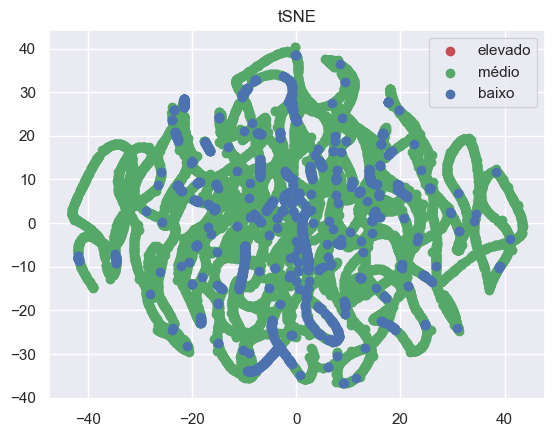

In [31]:
tsne = TSNE(n_components=3, n_iter=1000)
points = tsne.fit_transform(X)
meta_values = data_Y_categorical["tm"]

plt.figure()
for c, name in zip("rgb", ["elevado", "médio", "baixo"]):
    plt.scatter(points[meta_values == name, 0], points[meta_values == name, 1], c=c, label=name)
plt.title("tSNE")
plt.legend(loc='best', shadow=False)
plt.show()


---
# Etapa 3 - Aprendisagem máquina

Vamos agora proceder ao treino de modelos de diferentes naturezas e estudar a sua capacidade de prever a termoestabilidade.

In [7]:
data_y = Y_categorical.replace(["muito baixo","baixo","baixo-médio","médio","médio-alto","alto","muito alto"], [0,1,2,3,4,5,6])
data_y.groupby("tm").size()

tm
0      611
1     1358
2     7428
3    13626
4     2739
5     1545
6     1036
dtype: int64

Dividir os dados em treino e em teste

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 500)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (21258, 77) (21258, 1)
Test:  (7086, 77) (7086, 1)


Regressão e curva roc

Original Model Scores (CV on train set): [0.23707553 0.21020994 0.21072589 0.22955425 0.23660555]
Score:  0.2306468698351185
Constante do modelo:  [48.85387786]
Parâmetros do modelo:  [[ 7.06172003e-06 -1.17559305e+00  1.15220551e+00 -1.65453530e+00
  -7.73146782e-01 -3.78216972e+03  4.70476983e-01  6.65027491e-02
  -2.16436789e-01 -4.44707080e-01 -5.69007828e-02  7.88308051e+00
  -5.74209850e+02 -4.75880324e+02 -4.61927646e+02 -3.38482805e+02
  -6.52394552e+02 -5.00577985e+02 -6.63671768e+02 -2.96895923e+02
   1.68642237e+03  2.07062929e+03 -6.98791143e+02 -2.91564473e+02
  -3.91069781e+02 -5.60605985e+02 -6.54942683e+02 -4.46792865e+02
  -2.32383291e+02 -3.69687346e+02  1.01254033e+03 -7.72917752e-02
  -6.43485999e-01 -1.13692969e-01 -4.42728910e-01  9.41337841e-01
   4.32857726e-01 -6.91467208e-01 -1.93263439e-01 -2.44454745e-01
   2.78789373e-01  5.54644186e-01 -6.60813621e-02 -6.18644271e-01
   3.47478635e-01 -8.37877624e-04 -1.97099757e-02 -4.84897768e-01
   1.77585230e-01  1.074

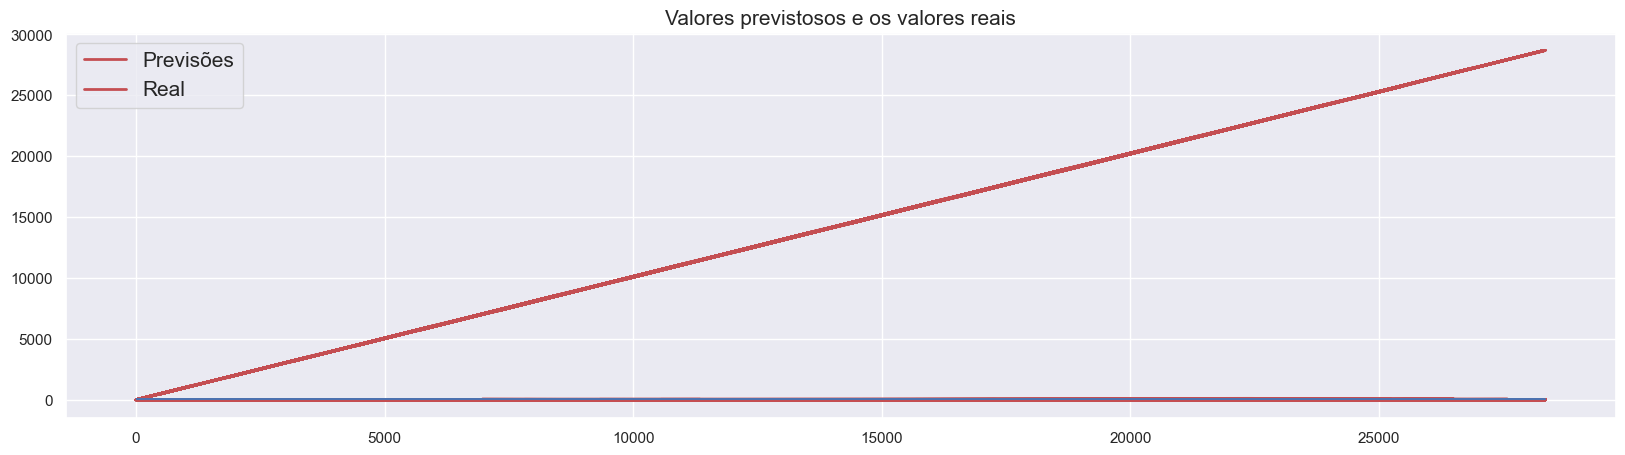

In [12]:
modelo = LinearRegression()
res = modelo.fit(X_train,y_train)
lr_scores = cross_val_score(res, X_train, y_train, cv=5)
print("Original Model Scores (CV on train set):", lr_scores)
print('Score: ', modelo.score(X_train,y_train))
print('Constante do modelo: ', modelo.intercept_)
print('Parâmetros do modelo: ', modelo.coef_)


plt.figure(figsize=(20,5))
plt.plot(X_train, linewidth=2, color='r')
plt.plot(y_train, linewidth=0.5,color='b')
plt.title('Valores previstosos e os valores reais',size=15)
plt.legend(['Previsões','Real'],fontsize=15)
plt.show()

In [32]:
# Função auxiliar
def score_test_set(model, X_test, y_test):
    # score test set
    y_pred = model.predict(X_test)
    try:
        y_prob = model.predict_proba(X_test)
    except:
        y_prob = None
    print('accuracy', accuracy_score(y_test, y_pred))
    print('MCC', matthews_corrcoef(y_test, y_pred))
    print('f1 score', f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('fdr', float(fp) / (tp + fp))
    print('sn', float(tp) / (tp + fn))
    print('sp', float(tn) / (tn + fp))

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [62]:
# Demora muito tempo a correr
param_grid = {'C': [0.01,0.1,1],
#               'C': [0.1, 1, 10]
              'kernel': ['linear']}

#hyperparameter optimization algorithm
grid = GridSearchCV(SVR(), param_grid, cv=5, refit = True, verbose = 3)
# fitting the model for grid search
grid.fit(X_train, y_train)
print(grid.best_params_)


#SCORE THE TEST SET
score_test_set(grid, X_test, y_test)


#feature importance
pd.Series(abs(grid.best_estimator_.coef_[0]), index="columns").nlargest(20).plot(kind='barh')


Fitting 5 folds for each of 3 candidates, totalling 15 fits


RandomForest sem pesos com RandomizedSearchCV

In [35]:
param_grid = {'n_estimators': [10, 50]}

#hyperparameter optimization algorithm
grid = RandomizedSearchCV(RandomForestRegressor(), param_grid, cv=5, refit = True, verbose = 3)
# fitting the model for grid search
grid.fit(X_train, y_train)
print(grid.best_params_)
#SCORE THE TEST SET
#score_test_set(grid, X_test, y_test["tm"])

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ...................n_estimators=10;, score=0.565 total time=   7.9s
[CV 2/5] END ...................n_estimators=10;, score=0.526 total time=   8.1s
[CV 3/5] END ...................n_estimators=10;, score=0.545 total time=   7.8s
[CV 4/5] END ...................n_estimators=10;, score=0.553 total time=   8.0s
[CV 5/5] END ...................n_estimators=10;, score=0.550 total time=   8.7s
[CV 1/5] END ...................n_estimators=50;, score=0.593 total time=  40.7s
[CV 2/5] END ...................n_estimators=50;, score=0.577 total time=  39.6s
[CV 3/5] END ...................n_estimators=50;, score=0.580 total time=  40.1s
[CV 4/5] END ...................n_estimators=50;, score=0.601 total time=  41.9s
[CV 5/5] END ...................n_estimators=50;, score=0.590 total time=  41.0s
{'n_estimators': 50}


ValueError: continuous is not supported

<AxesSubplot: >

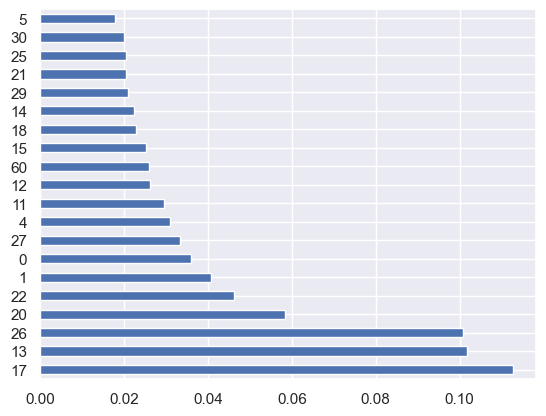

In [39]:
# feature importance for RF
pd.Series(abs(grid.best_estimator_.feature_importances_)).nlargest(20).plot(kind='barh')

# Etapa 4 - Deep learning
Nas partes iniciais foram realizadas actividades de limpeza dos dados, estudo das featurese e feature engineering, dando-nos agora um dataset de maior qualidade para usar no desenvolvimento duma rede neuronal capaz de prever o `tm` de forma adequada. Para tal, há alguns factores que precisamos de ter em conta ao densenvolver o modelo, nomeadamente:
- É importante saber qual deve ser a estrutura do modelo - número de camadas, tipos de layers, número de nodos das camadas, etc. 
- Para além dos parâmetros (que a própria rede vai procurar optimizar), existem também os hiperparâmetros, cuja optimização não é parte do algoritmo de backpropagation, e deve também ser feita.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, LeaveOneOut, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")
# load dataset after processing
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

dataset = pd.read_csv('datasets/all_descriptors_processed.csv', delimiter = ',')
Y = dataset["tm"].to_frame(name = "tm")
X = dataset.drop("tm", axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 500)

print('Train: ', X_train.shape, Y_train.shape)
print('Test: ', X_test.shape, Y_test.shape)

# funções auxiliares
def print_model(model,fich):
    plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)

def create_time_steps(length):
  return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
  print(history)
  print(true_future)
  print(prediction)
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/72, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/72, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.show()

Train:  (22675, 77) (22675, 1)
Test:  (5669, 77) (5669, 1)


In [2]:
def create_model(activation_func="tanh") -> Sequential:
    # Inicializar o modelo como um modelo de camadas sequenciais
    model = Sequential()
    n_features = X.shape[1]
    # Adicionar as layers do modelo
    model.add(Input(shape = (n_features, )))
    model.add(Dense(n_features, activation=activation_func))
    model.add(Dense(n_features, activation=activation_func))
    model.add(Dense(n_features, activation=activation_func))
    model.add(Dense(n_features, activation=activation_func))
    model.add(Dense(n_features, activation=activation_func))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'mse', optimizer = 'adam') # verificar params
    # Retornar modelo compilado
    return model

Para o processo de optimização vamos começar por fazer uma grid search para procurar os hiperparâmetros óptimos. Para começar, vejamos o batch size e o número de épocas.

In [3]:
param_grid = {
    "epochs" : [5, 20],
    "batch_size" : [5, 24, 32, 64, 80, 100],
}
estimator = KerasRegressor(build_fn = lambda: create_model(), epochs=100)
predictor = RandomizedSearchCV(estimator, param_distributions=param_grid, n_iter=10, scoring="neg_mean_squared_error",n_jobs=90)
predictor.fit(X_train,Y_train)

Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/5
Epoch 1/20
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/20
Epoch 1/5
Epoch 1/20
Epoch 1/5
Epoch 1/20
Epoch 1/5
Epoch 1/20
 28/227 [==>...........................] - ETA: 0s - loss: 2454.1035  Epoch 1/5
Epoch 1/5
120/756 [===>..........................] - ETA: 0s - loss: 2492.1311Epoch 1/5
Epoch 1/5
  1/756 [..............................] - ETA: 10:08 - loss: 2541.4050Epoch 1/5
Epoch 1/5
 55/567 [=>............................] - ETA: 0s - loss: 2459.6340Epoch 1/5
Epoch 1/5
173/756 [=====>........................] - ETA: 0s - loss: 2469.1079Epoch 1/5
Epoch 1/20
 14/756 [..............................] - ETA: 2s - loss: 2375.5208  Epoch 1/5
Epoch 1/20
 21/756 [..............................] - ETA: 1s - loss: 2536.6902   Epoch 1/5
Epoch 1/20
Epoch 1/20
  82/3628 [..............................] - ETA: 6s - loss: 2420.3289Epoch 1/5
Epoch 1/20
 74/567 [==>............

RandomizedSearchCV(estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7ff7184677f0>,
                   n_jobs=90,
                   param_distributions={'batch_size': [5, 24, 32, 64, 80, 100],
                                        'epochs': [5, 20]},
                   scoring='neg_mean_squared_error')

In [4]:
print(predictor.best_params_)
Y_pred = predictor.predict(X_test)
print("mean_absolute_percentage_error:", mean_absolute_percentage_error(Y_test,Y_pred)*100, "(%)")
print("R2:", r2_score(Y_test,Y_pred))
# isto não aprende!

{'epochs': 20, 'batch_size': 80}
71/71 [==============================] - 0s 583us/step
mean_absolute_percentage_error: 97.7900225766643 (%)
R2: -14.173807956461573


Como o R2 é muito mau, inclusive abaixo de zero, nenhuma da variância está a ser explicada. Isto, em conjunção com um mean absolute percentage error de quase 100% leva a crer que o modelo está simplesmente a fazer disparates.

Daqui, podemos seguir por dois caminhos:
1. efectuar alterações no tratamento dos dados, possivelmente para ajustar o `tm` para uma outra distribuição e.g. a normal
2. modificar o modelo usado, quer optimizando os hiperparâmetros (com mais valores, ou outros parâmetros por completo como as funções), quer alterando as próprias layers, experimentando com camadas convolucionais, por exemplo.

Vamos então pela segunda opção e começar por trocar a função de ativação usada à saída do modelo. 

In [5]:
def create_model(activation_func="tanh") -> Sequential:
    # Inicializar o modelo como um modelo de camadas sequenciais
    model = Sequential()
    n_features = X.shape[1]
    # Adicionar as layers do modelo
    model.add(Input(shape = (n_features, )))
    model.add(Dense(n_features, activation=activation_func))
    model.add(Dense(n_features, activation=activation_func))
    model.add(Dense(n_features, activation=activation_func))
    model.add(Dense(n_features, activation=activation_func))
    model.add(Dense(n_features, activation=activation_func))
    model.add(Dense(1, activation='linear'))
    model.compile(loss = 'mse', optimizer = 'adam') # verificar params
    # Retornar modelo compilado
    return model

param_grid = {
    "epochs" : [5, 20],
    "batch_size" : [5, 24, 32, 64, 80, 100],
}
estimator = KerasRegressor(build_fn = lambda: create_model(), epochs=100) # learning_rate = 0.01, activation = 'tanh'
predictor = RandomizedSearchCV(estimator, param_distributions=param_grid, n_iter=10, scoring="neg_mean_squared_error",n_jobs=90)
predictor.fit(X_train,Y_train)

Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
284/284 [==============================] - 1s 1ms/step - loss: 1098.3230
Epoch 2/5
284/284 [==============================] - 0s 1ms/step - loss: 353.6721
Epoch 3/5
182/182 [==============================] - 1s 2ms/step - loss: 1219.4286
Epoch 2/5
182/182 [==============================] - 1s 2ms/step - loss: 1260.8395
Epoch 2/5
284/284 [==============================] - 1s 1ms/step - loss: 997.2988
Epoch 2/5
182/182 [==============================] - 1s 2ms/step - loss: 1279.7009
Epoch 2/5
182/182 [==============================] - 1s 2ms/step - loss: 1260.6112
Epoch 2/5
182/182 [==============================] - 1s 2ms/step - loss: 1270.1416
Epoch 2/5
284/284 [==============================] - 1s 1ms/step - loss: 1020.1162
Epoch 2/5
182/182 [==============================] - 0s 1ms/step - loss: 566.5999
Epoch 3/5
182/182 [==============================] - 0s 1ms/step - loss: 566.6077
E

RandomizedSearchCV(estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7ff7184670d0>,
                   n_jobs=90,
                   param_distributions={'batch_size': [5, 24, 32, 64, 80, 100],
                                        'epochs': [5, 20]},
                   scoring='neg_mean_squared_error')

In [6]:
print(predictor.best_params_)
Y_pred = predictor.predict(X_test)
print("mean_absolute_percentage_error:", mean_absolute_percentage_error(Y_test,Y_pred)*100, "(%)")
print("R2:", r2_score(Y_test,Y_pred))

{'epochs': 5, 'batch_size': 32}
178/178 [==============================] - 0s 537us/step
mean_absolute_percentage_error: 21.21702436600973 (%)
R2: -7.0618407546074735e-06


Com esta aparentemente pequena alteração foi possível melhorar imenso a qualidade do predictor, com a percentagem de erro nas previsões a baixar aproximadamente 76%. Ainda assim, estes 20 indicam que há margem para melhorar.
Curiosamente, o R quadrado melhorou mas ficou perto de 0, o que continua a ser mau e sugere que a variância verificada nas previsões não é explicada pelo modelo. Este valor poderia tecnicamente ser influenciado por factores externos como as unidades de medida das features (escalas muito diferentes), mas como o dataset já foi submetido ao Standard Scaler, este factor já não justifica o valor de R2.